# 藥物原料、feeder、contextual data對應
1. API：原料為Acetaminophen powder(APAP_P)、feed by PD3
2. MGST：原料為Magnesium stearate(Mag St)、feed by PD7
3. Loctose：原料為Spray dried lactose (L316FF)、feed by PD2
4. Ac-di-sol：Sodium croscarmellose (Ac-di-sol)、feed by PD5
5. Avicel PH102：原料為Microcrystalline cellulose, Avicel PH102，會有兩個批號同時供應、feed by PD1 and PD4

In [2]:
import pandas as pd
import numpy as np

In [3]:
# machine data
liw_feeders_1 = pd.read_csv("MSOM data external sharing\Machine data\LiW Feeders 1.csv")
liw_feeders_2 = pd.read_csv("MSOM data external sharing\Machine data\LiW Feeders 2.csv")
blenders = pd.read_csv("MSOM data external sharing\Machine data\Blenders.csv")
pressor = pd.read_csv("MSOM data external sharing\Machine data\Tablet Press.csv")
temperature = pd.read_csv("MSOM data external sharing\Machine data\Temperature.csv")
humidity = pd.read_csv("MSOM data external sharing\Machine data\Humidity.csv")

C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4085920741.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  liw_feeders_1 = pd.read_csv("MSOM data external sharing\Machine data\LiW Feeders 1.csv")
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4085920741.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  liw_feeders_2 = pd.read_csv("MSOM data external sharing\Machine data\LiW Feeders 2.csv")
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4085920741.py:4: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  blenders = pd.read_csv("MSOM data external sharing\Machine data\Blenders.csv")
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4085920741.py:5: DtypeWarning: Columns (1,2,3

In [4]:
# concat liw_feeder1&2
liw_feeder = pd.concat([liw_feeders_1, liw_feeders_2], axis=1)
liw_feeder = liw_feeder.loc[:, ~liw_feeder.columns.str.contains("Unnamed:")]

In [5]:
#日期處理
def parse_mixed_date(date_str):
    try:
        # 嘗試美式日期
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        try:
            # 如果失敗，改用歐洲格式
            return pd.to_datetime(date_str, format="%d/%m/%Y %H:%M")
        except:
            return pd.NaT


liw_feeder["TimeStamp"] = liw_feeder["TimeStamp"].apply(parse_mixed_date)
blenders["TimeStamp"] = blenders["TimeStamp"].apply(parse_mixed_date)
pressor["TimeStamp"] = pressor["TimeStamp"].apply(parse_mixed_date)


liw_feeder = liw_feeder.dropna(subset=["TimeStamp"], how="any")
blenders = blenders.dropna(subset=['TimeStamp'], how="any")
pressor = pressor.dropna(subset=['TimeStamp'], how="any")

In [6]:
# 直接嘗試自動解析，錯誤時返回 NaT
def parse_mixed_date_series(date_series):
    return pd.to_datetime(date_series, errors='coerce', infer_datetime_format=True)

# 批量應用到 DataFrame
for df in [liw_feeder, blenders, pressor]:
    df["TimeStamp"] = parse_mixed_date_series(df["TimeStamp"])
    df.dropna(subset=["TimeStamp"], inplace=True)

C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\1360516746.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(date_series, errors='coerce', infer_datetime_format=True)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\1360516746.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(date_series, errors='coerce', infer_datetime_format=True)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\1360516746.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict v

In [7]:
# contextual quality
logbook = pd.read_excel("MSOM data external sharing\Contextual quality data\Logbook Long Run Days.xlsx")
content = pd.read_excel("MSOM data external sharing\Contextual quality data\RM Content Uniformity.xlsx", header=1)
material_property = pd.read_excel("MSOM data external sharing\Contextual quality data\RM Material Properties.xlsx")
tablet_property = pd.read_excel("MSOM data external sharing\Contextual quality data\RM Tablet Properties and Drum Change.xlsx", sheet_name="Tablet properties", header=1)
drum_change = pd.read_excel("MSOM data external sharing\Contextual quality data\RM Tablet Properties and Drum Change.xlsx", sheet_name="Raw Material Drum change", header=1)

In [8]:
# tablet_property 處理
tablet_property = tablet_property.dropna(axis=0, how="all")

In [9]:
# drum_change 處理
api = drum_change.iloc[1:, 0:4].dropna(axis=0, how="all")
mgst = drum_change.iloc[1:, 4:8].dropna(axis=0, how="all")
lactose = drum_change.iloc[1:, 8:12].dropna(axis=0, how="all")
Ac_Di_Sol = drum_change.iloc[1:, 12:16].dropna(axis=0, how="all")
Avicel_102_PD1 = drum_change.iloc[1:, 16:20].dropna(axis=0, how="all")
Avicel_102_PD4 = drum_change.iloc[1:, 20:24].dropna(axis=0, how="all")

api = api[api["Est Refill time"] != "missing"]
api = api.reset_index(drop=True)
mgst = mgst.rename(columns={"Date/Time.1": "Date/Time", "Lot.1":"Lot"})
lactose = lactose.rename(columns={"Date/Time.2": "Date/Time"})
Ac_Di_Sol = Ac_Di_Sol.rename(columns={"Date/Time.3": "Date/Time", "Drum #.1": "Drum #"})
Avicel_102_PD1 = Avicel_102_PD1.rename(columns={"Date/Time.4": "Date/Time", "Drum #.2": "Drum #"})
Avicel_102_PD4 = Avicel_102_PD4.rename(columns={"Date/Time.5": "Date/Time", "Drum #.3": "Drum #"})

In [10]:
# first day
# machine data
time_till_first_day = 60 * 60 * 15 + 60 * 17 - 5
liw_feeder_first_day = liw_feeder[:time_till_first_day]
blenders_first_day = blenders[:time_till_first_day]
pressor_first_day = pressor[:time_till_first_day]

# contextual data
api_first_day = api[:7]
mgst_first_day = mgst[:6]
lactose_first_day = lactose[:3]
Ac_Di_Sol_first_day = Ac_Di_Sol[:2]
Avicel_102_PD1_first_day = Avicel_102_PD1[:4]
Avicel_102_PD4_first_day = Avicel_102_PD4[:4]

In [11]:
data_set = {
    "API": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    },
    "MGST": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    },
    "Lactose": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    },
    "Ac_Di_Sol": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    },
    "Avicel_102_PD1": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    },
    "Avicel_102_PD4": {
        "liw_feeder": {},
        "blenders": {},
        "pressor": {}
    }
}

In [12]:
# Based on the sampling interval of output type, find the data points of liw_feeder、blenders、pressor in each time interval.
# 設定時間區間
def time(i: int, input: pd.DataFrame):
    if i == len(input) - 1: 
        return f'After {input.iloc[i]["Date/Time"]}'
    return f'{input.iloc[i+1]["Date/Time"]}'

# 根據時間區間確定那些process data應該要放入
def data_within_time(i: int, input: pd.DataFrame, process: pd.DataFrame):
    # 在input的第一個時間之前的process data
    if i == -1:
        return process[process["TimeStamp"] <= input.iloc[i+1]["Date/Time"]]
    # 在input的最後一個時間之後的process data
    if i == len(input) - 1:
        return process[process["TimeStamp"] >= input.iloc[i-1]["Date/Time"]]

    return process[(process["TimeStamp"] > input.iloc[i]["Date/Time"]) & (process["TimeStamp"] < input.iloc[i+1]["Date/Time"])]

# 標記record的batch
def set_process_data_batch(data_set: pd.DataFrame, input_key:str, process_key:str, input: pd.DataFrame, process: pd.DataFrame):
    
    batch_name = "Drum #"

    # 如果是API或MGST的話就將batch_name換為Lot
    if input_key == "API" or input_key == "MGST":
        batch_name = "Lot"

    print(input_key, batch_name)
    keys = list(data_set[input_key][process_key].keys())

    # init batch column
    for key in keys:
        # init batch column
        data_set[input_key][process_key][key]["Batch"] = 0

        #建立batch的bins
        bins = list(input["Date/Time"]) + [pd.Timestamp.max]
        labels = input[batch_name].astype(str)

        # 分配對應批次
        data_set[input_key][process_key][key]["Batch"] = pd.cut(data_set[input_key][process_key][key]["TimeStamp"], bins=bins, labels=labels, right=False, ordered=False)

In [13]:
# 依據input與process將data區分
input_keys = list(data_set.keys())
process_keys = list(data_set['API'].keys())

inputs = [api_first_day, mgst_first_day, lactose_first_day, Ac_Di_Sol_first_day, Avicel_102_PD1_first_day, Avicel_102_PD4_first_day]
process = [liw_feeder_first_day, blenders_first_day, pressor_first_day]

for i, input_key in enumerate(input_keys):
    for j, process_key in enumerate(process_keys):
        k = -1
        while k < len(inputs[i]):
            data_set[input_key][process_key][time(k, inputs[i])] = data_within_time(k, inputs[i], process[j])
            k += 1

for i, input_key in enumerate(input_keys):
    for j, process_key in enumerate(process_keys):
        set_process_data_batch(data_set, input_key, process_key, inputs[i], process[j])

API Lot
API Lot
API Lot
MGST Lot
MGST Lot
MGST Lot
Lactose Drum #
Lactose Drum #
Lactose Drum #
Ac_Di_Sol Drum #
Ac_Di_Sol Drum #
Ac_Di_Sol Drum #
Avicel_102_PD1 Drum #


C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[input_key][process_key][key]["Batch"] = 0
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[input_key][process_key][key]["Batch"] = pd.cut(data_set[input_key][process_key][key]["TimeStamp"], bins=bins, labels=labels, right=False, ordered=False)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:34: SettingWi

Avicel_102_PD1 Drum #
Avicel_102_PD1 Drum #
Avicel_102_PD4 Drum #
Avicel_102_PD4 Drum #
Avicel_102_PD4 Drum #


C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[input_key][process_key][key]["Batch"] = pd.cut(data_set[input_key][process_key][key]["TimeStamp"], bins=bins, labels=labels, right=False, ordered=False)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set[input_key][process_key][key]["Batch"] = 0
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\4159984350.py:41: SettingWi

In [14]:
# 因為最內層的key是由inputs決定，所以process用甚麼都沒關係
api_keys = list(data_set["API"]["liw_feeder"].keys())
mgst_keys = list(data_set["MGST"]["liw_feeder"].keys())
lactose_keys = list(data_set['Lactose']["liw_feeder"].keys())
Ac_Di_Sol_keys = list(data_set['Ac_Di_Sol']["liw_feeder"].keys())
Avicel_102_PD1_keys = list(data_set['Avicel_102_PD1']["liw_feeder"].keys())
Avicel_102_PD4_keys = list(data_set['Avicel_102_PD4']["liw_feeder"].keys())

# 將keys整合成一個二維陣列
output_keys = [api_keys, mgst_keys, lactose_keys, Ac_Di_Sol_keys, Avicel_102_PD1_keys, Avicel_102_PD4_keys]

# Contextual Data的標記
根據contextual sampling的時間做區隔

## Data Concat
1. 將contextual data加入process不同時間段的資料中
2. 將process不同時間段的data frame垂直整合
3. 將input中不同的process橫向整合

In [15]:
# 標記contextual record的batch
def set_contextual_data_bin(input: pd.DataFrame, sampling_bins: list):
    # 在process表格中，加入contextual sampling 的時間
    bins = [pd.Timestamp.min] + list(sampling_bins)
    labels = sampling_bins

    input["sample_time"] = pd.cut(input["TimeStamp"], bins=bins ,labels=labels, right=False, ordered=False)

In [16]:
# easy for testing
# it should be only have content_first_day = content[:26]

content = pd.read_excel("MSOM data external sharing\Contextual quality data\RM Content Uniformity.xlsx", header=1)
content = content.iloc[:, :-1]
content_first_day = content[:26]

In [17]:
result = {
    "API": pd.DataFrame(),
    "MGST": pd.DataFrame(),
    "Lactose": pd.DataFrame(),
    "Ac_Di_Sol": pd.DataFrame(),
    "Avicel_102_PD1": pd.DataFrame(),
    "Avicel_102_PD4": pd.DataFrame()
}

result_keys = list(result.keys())

for i, input_key in enumerate(input_keys):
    for process_key in process_keys:
        process_temp = pd.DataFrame()

        # 設定contextual data的時間區間
        # 並將process中不同的時間區間的dataframe合併
        for output_key in output_keys[i]:
            set_contextual_data_bin(data_set[input_key][process_key][output_key], list(content_first_day['Time']))
            process_temp = pd.concat([process_temp, data_set[input_key][process_key][output_key]], axis=0)

        # 將input的不同process做水平合併
        result[input_key] = pd.concat([result[input_key], process_temp], axis=1)

C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\713355625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input["sample_time"] = pd.cut(input["TimeStamp"], bins=bins ,labels=labels, right=False, ordered=False)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\713355625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input["sample_time"] = pd.cut(input["TimeStamp"], bins=bins ,labels=labels, right=False, ordered=False)
C:\Users\蔡世玄\AppData\Local\Temp\ipykernel_17644\713355625.py:7: SettingWithCopyWarni

In [18]:
# 去除重覆的欄位
# 先檢查重覆的欄位所有cell是否相同
def remove_duplicate_columns(df):
    _, unique_idx = np.unique(df.columns, return_index=True)  # 找到唯一欄位的索引
    return df.iloc[:, np.sort(unique_idx)]  # 只保留唯一欄位

# 使用字典推導式來一次性處理所有 DataFrame
result = {key: remove_duplicate_columns(df) for key, df in result.items()}  

# 將result中的na去除
result = {key: df.dropna(axis=0, how="any") for key, df in result.items()}

In [19]:
# 將content uniformity合併進入df
for result_key in result_keys:
    result[result_key]['sample_time'] = pd.to_datetime(result[result_key]['sample_time'].astype(str), errors = 'coerce')
    result[result_key] = result[result_key].merge(content_first_day, left_on='sample_time', right_on='Time', how='left')
    result[result_key].drop(columns=['Time'], inplace=True)
    result[result_key].rename(columns={'Sample': 'sample_id'}, inplace=True)

In [20]:
# 將object轉為numeric
for result_key in result_keys:
    for col in result[result_key].select_dtypes(include=['object']).columns:
        result[result_key][col] = pd.to_numeric(result[result_key][col], errors='coerce')

In [21]:
# 依照資料順序將時間調整成依照秒數
for result_key in result_keys:
    result[result_key] = result[result_key].sort_index(ascending=False)

    result[result_key]['Timestamp_Count'] = 59 - result[result_key].groupby('TimeStamp').cumcount()
    result[result_key]['TimeStamp'] = result[result_key]['TimeStamp'] + pd.to_timedelta(result[result_key]['Timestamp_Count'], unit='s')
    result[result_key].drop(columns=['Timestamp_Count'], inplace=True)

    result[result_key] = result[result_key].sort_values(['TimeStamp'], ascending=True)

In [22]:
# 移動重要欄位到最前面
for result_key in result_keys:
    first_cols = ["TimeStamp","Batch", "sample_time", "sample_id"]
    cols = first_cols + [col for col in result[result_key] if col not in first_cols]
    result[result_key] = result[result_key][cols]

In [23]:
for result_key in result_keys:
    result[result_key].to_csv(f"processed_data/{result_key}.csv", index=False)

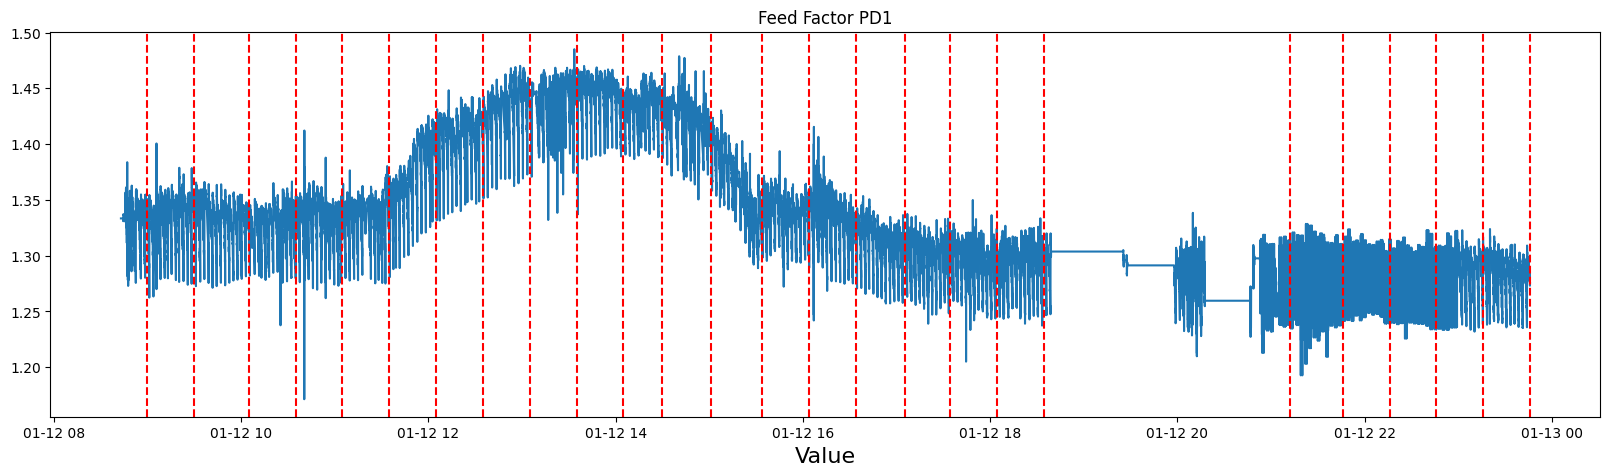

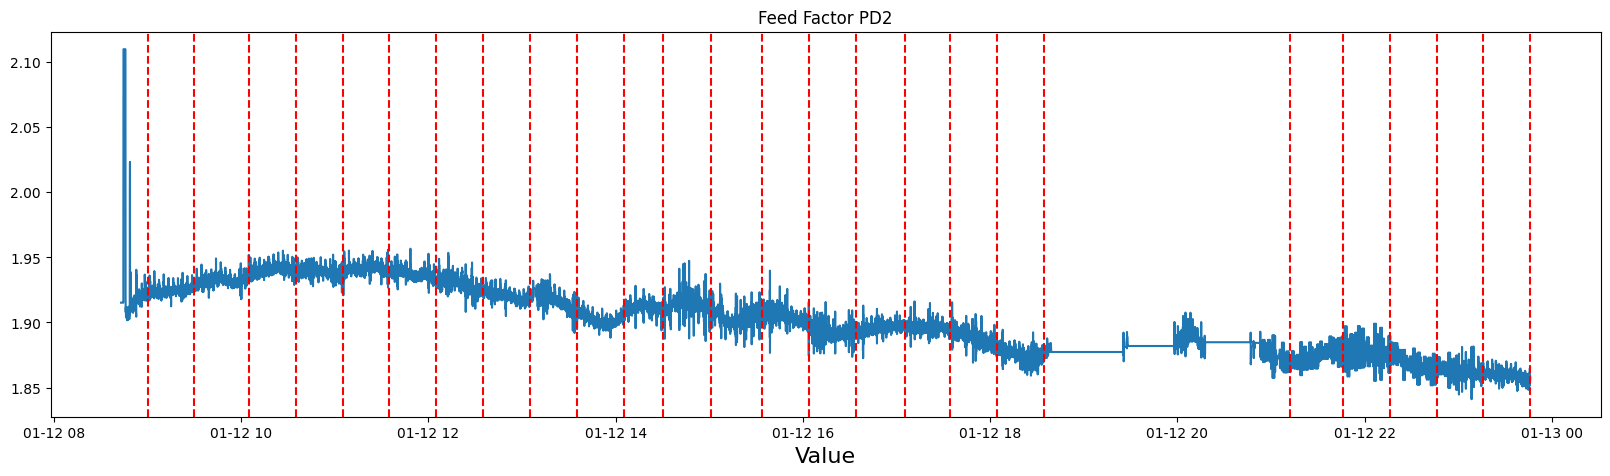

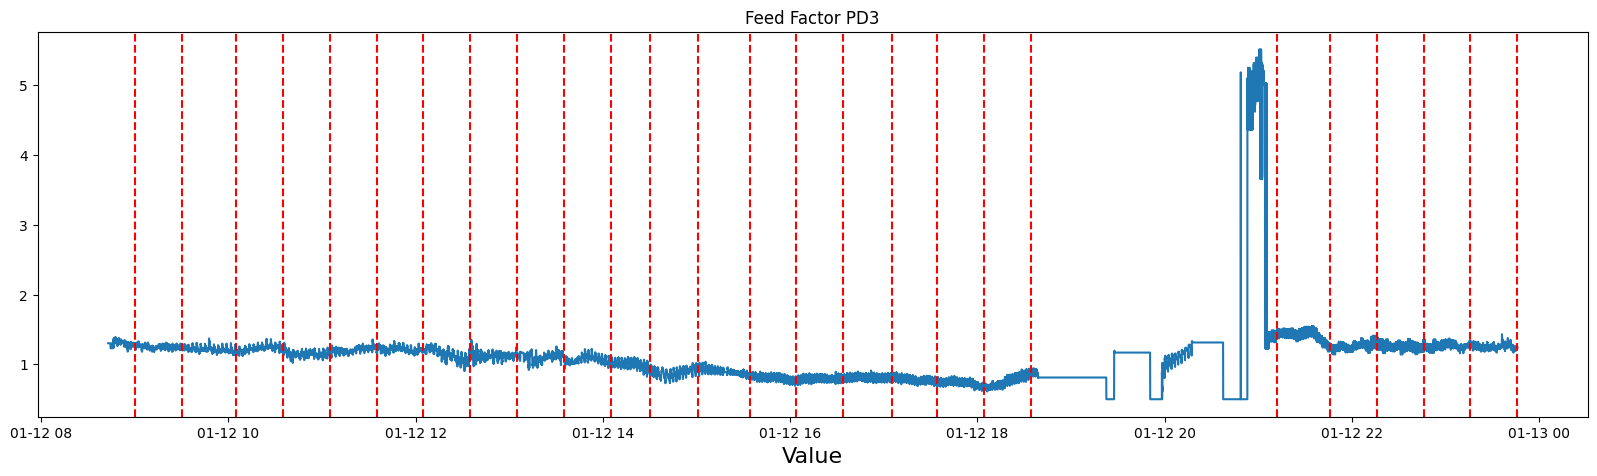

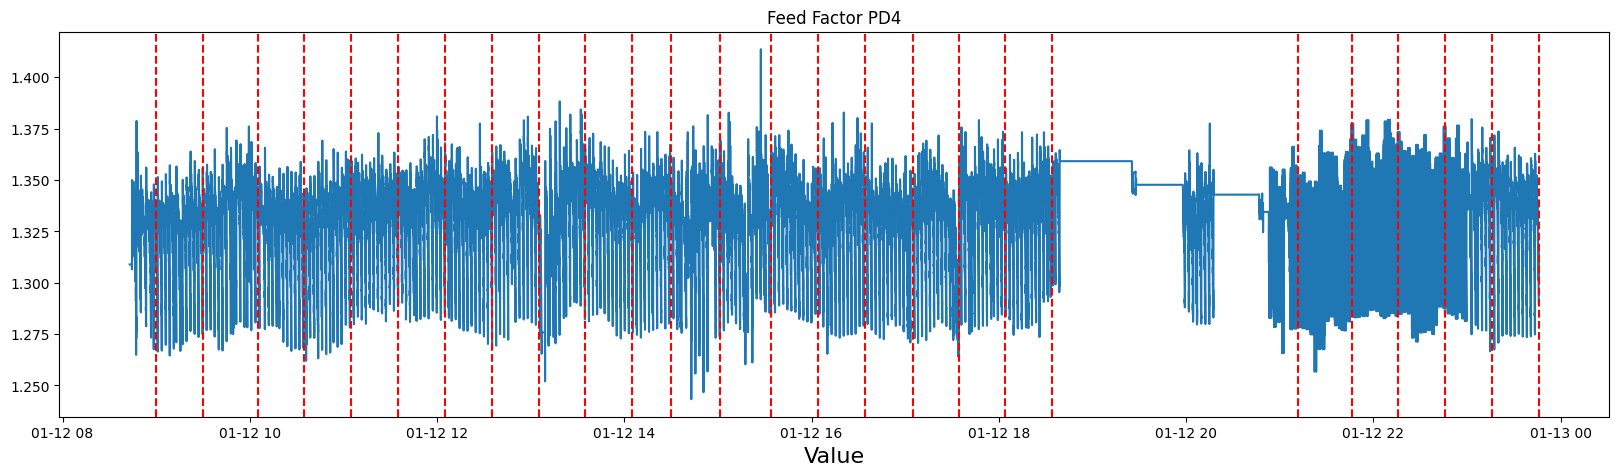

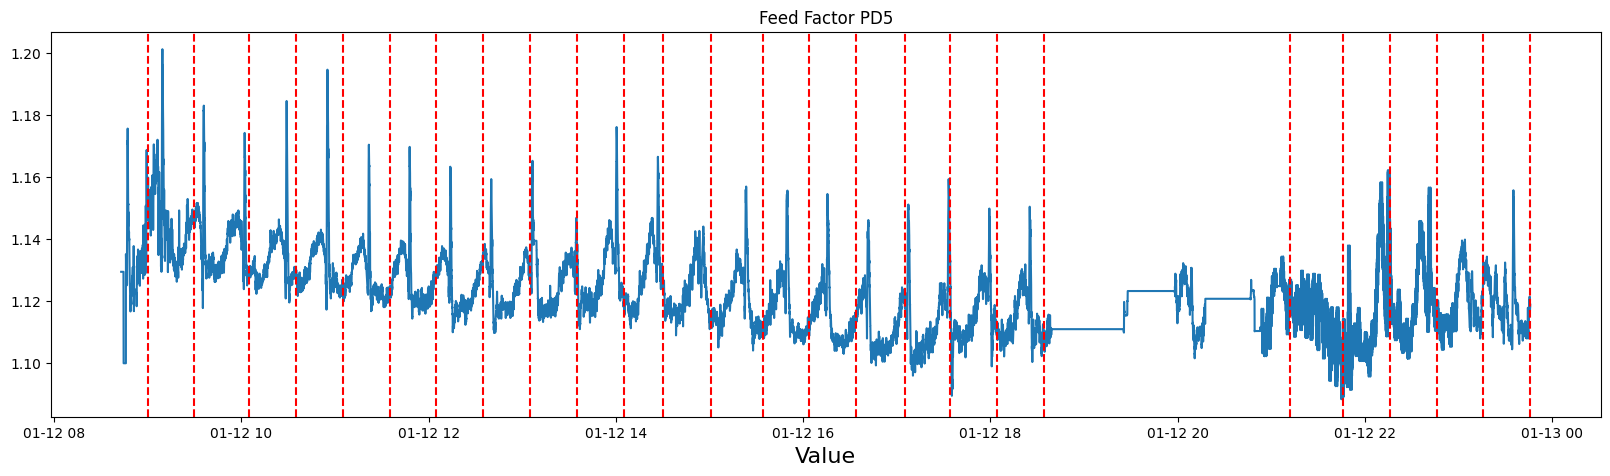

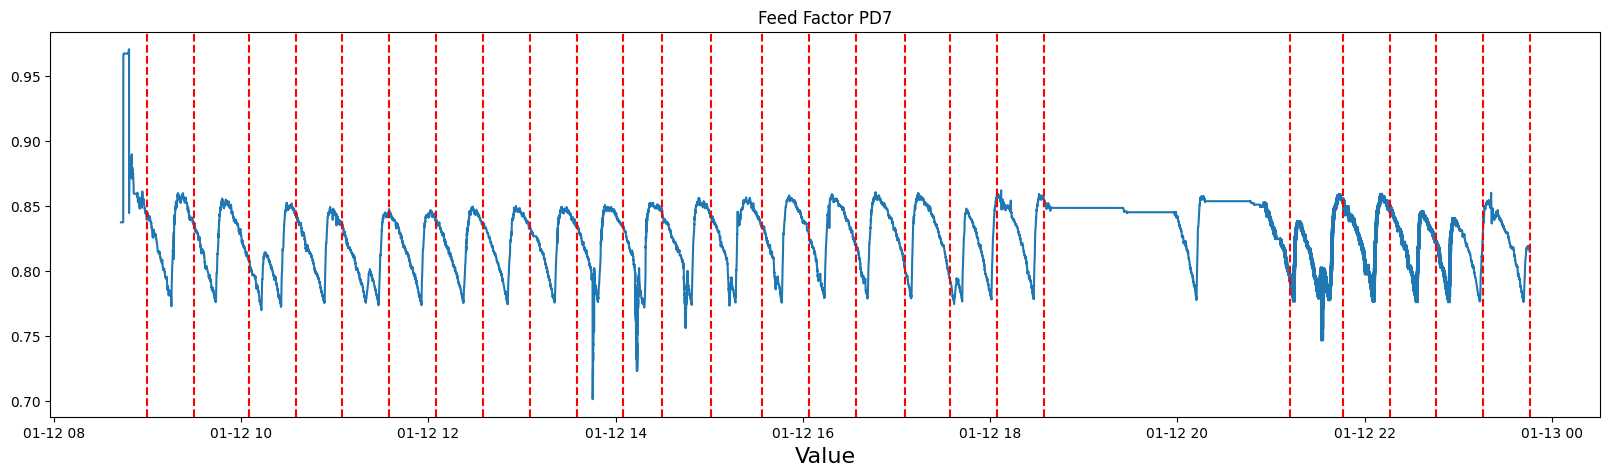

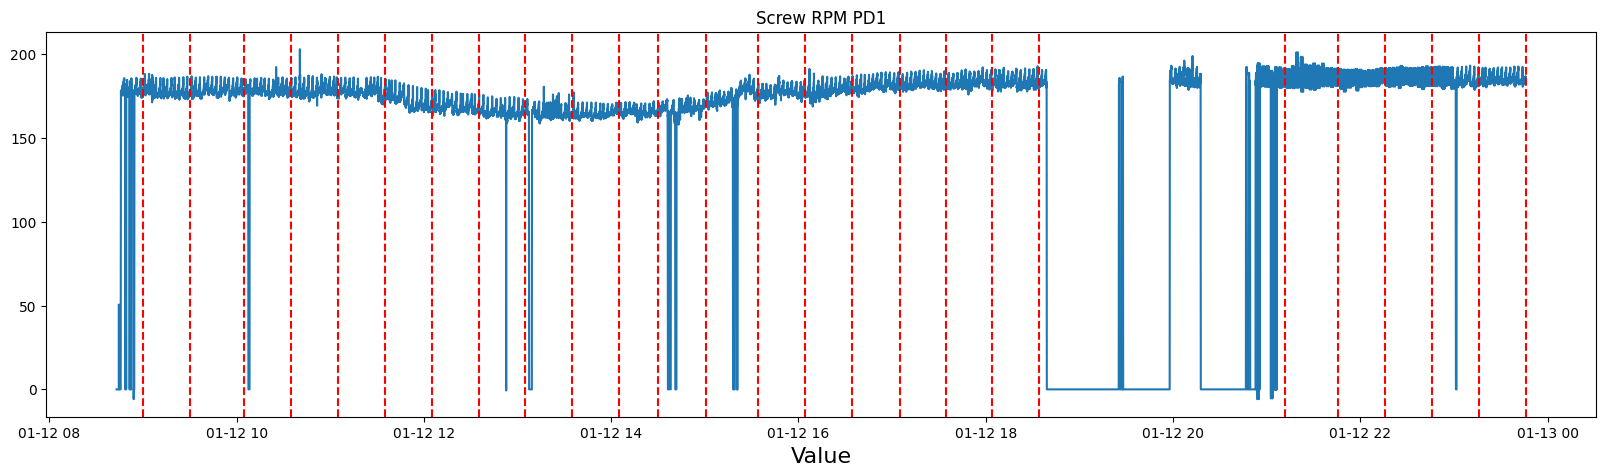

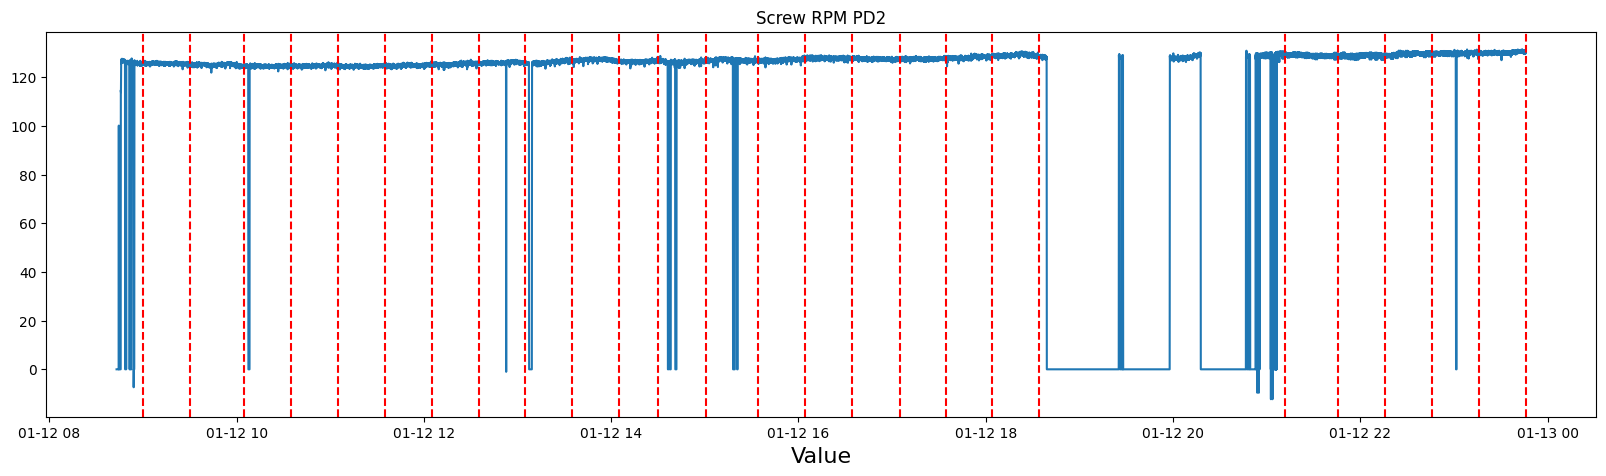

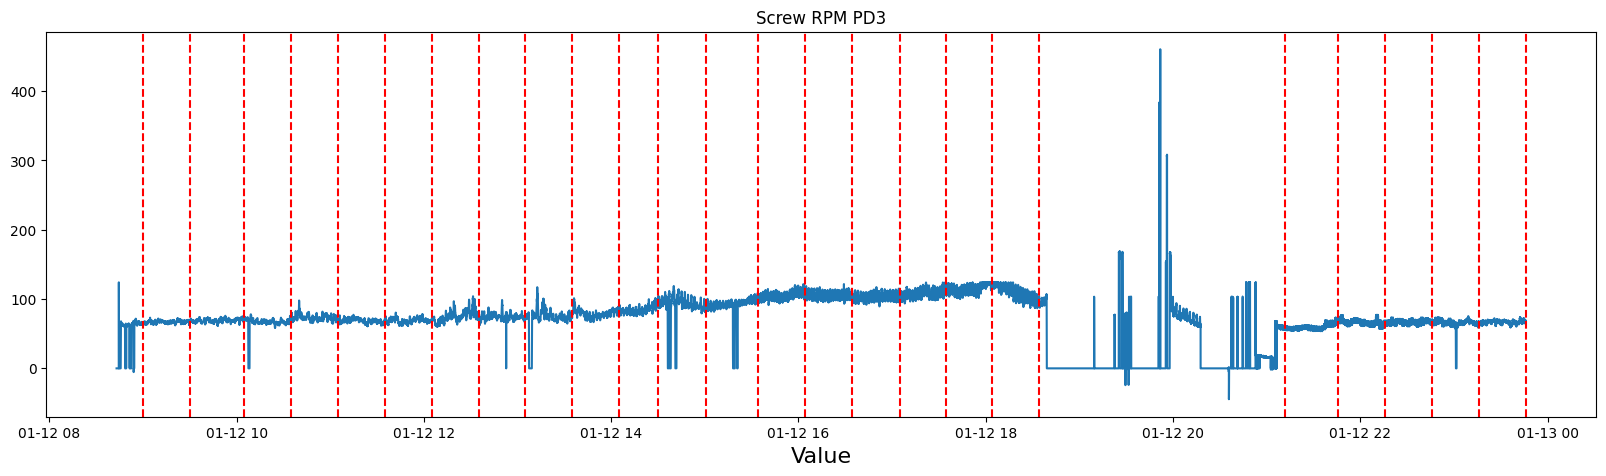

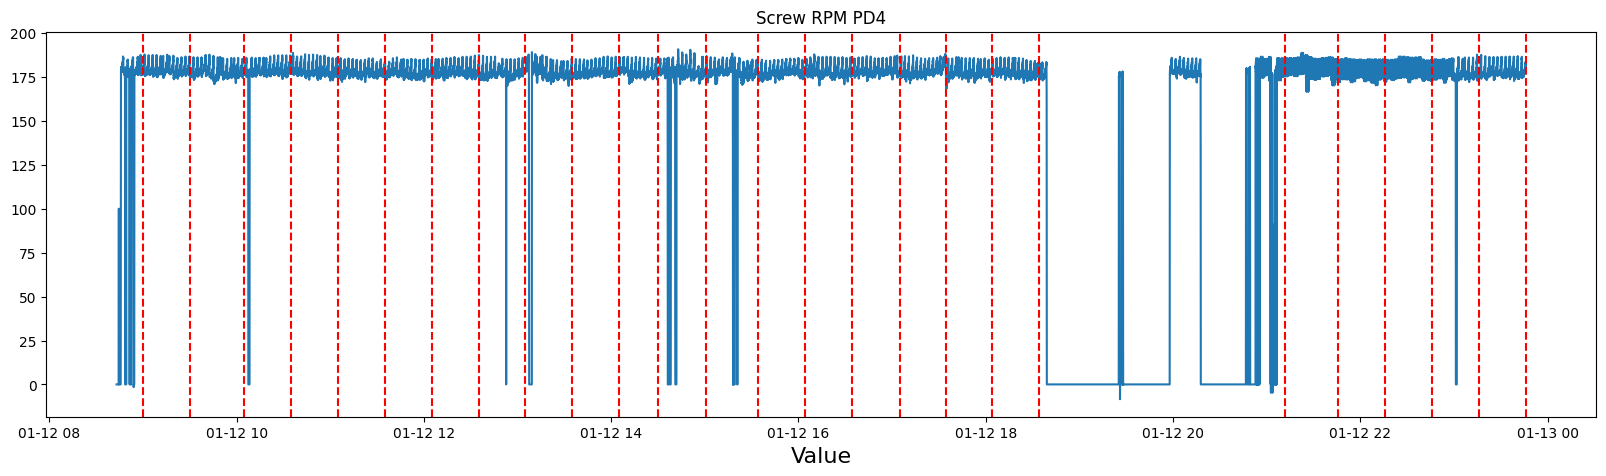

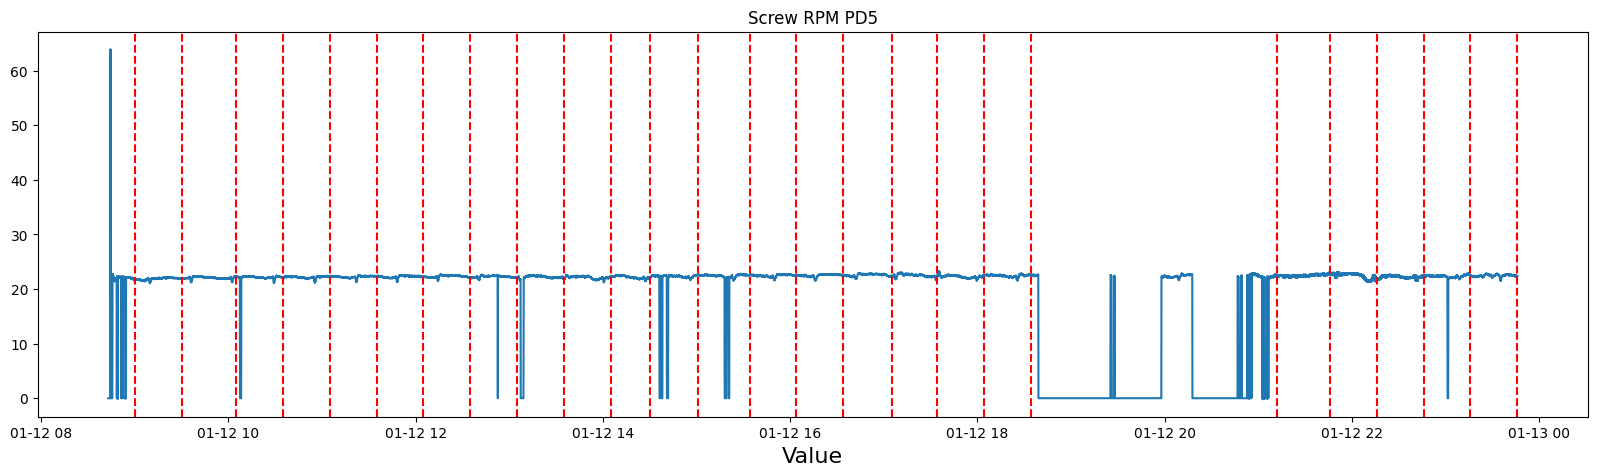

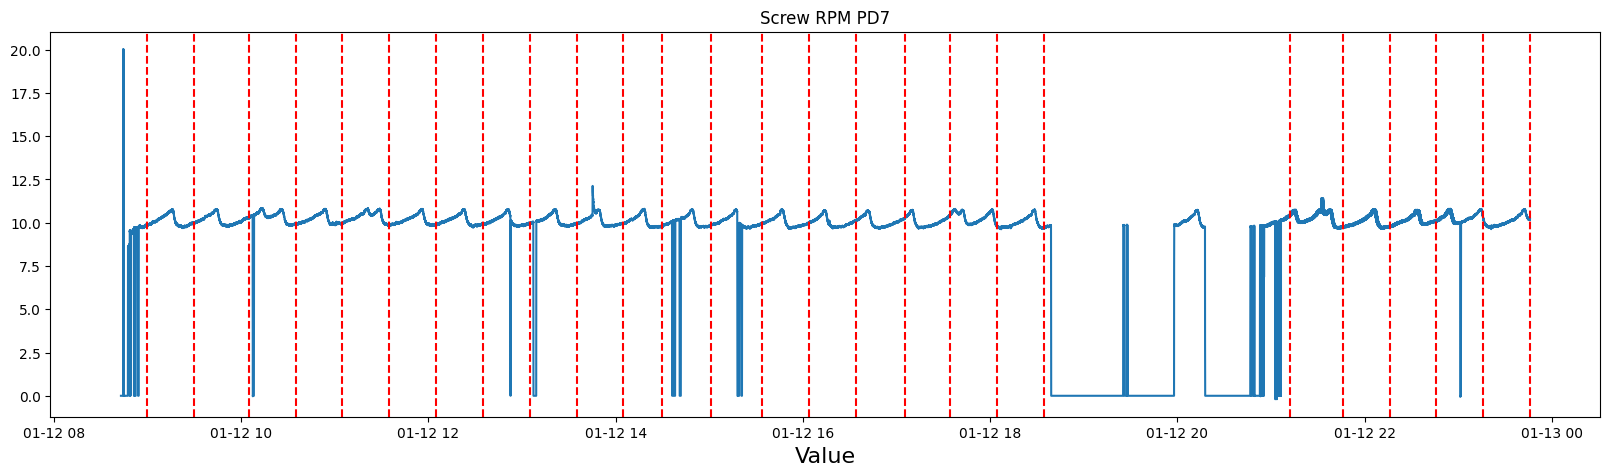

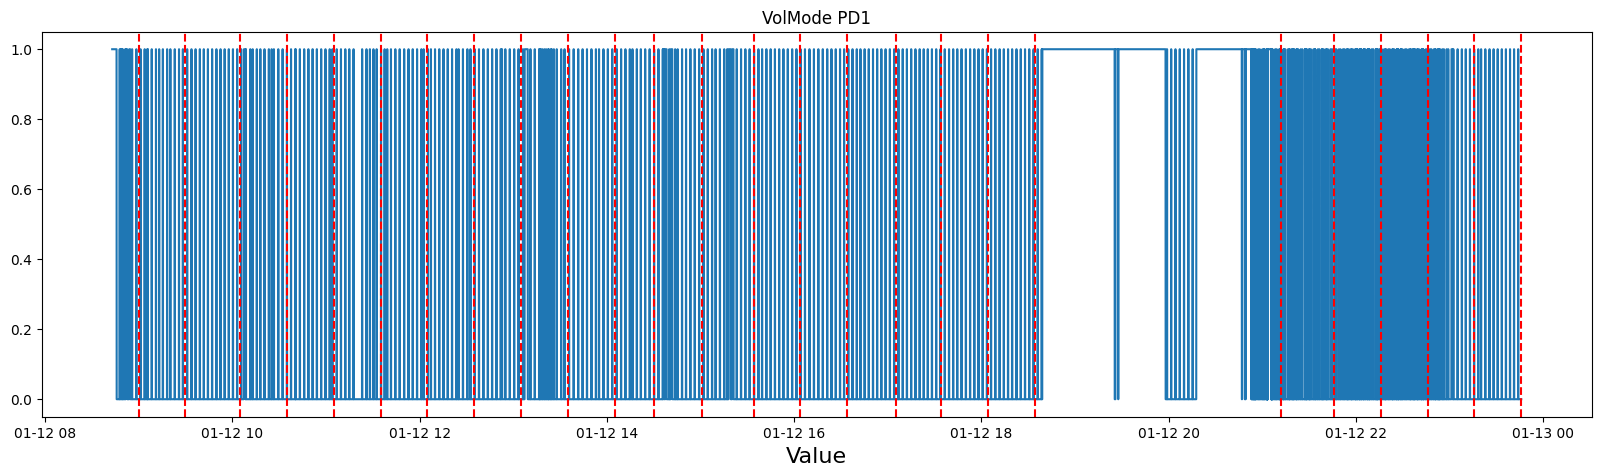

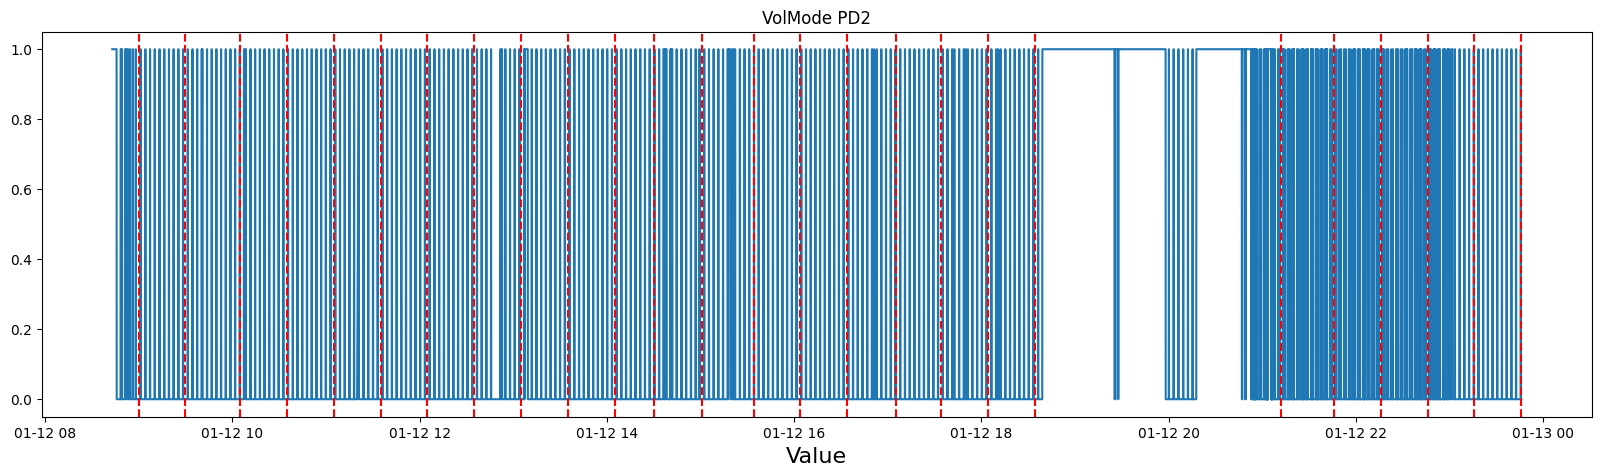

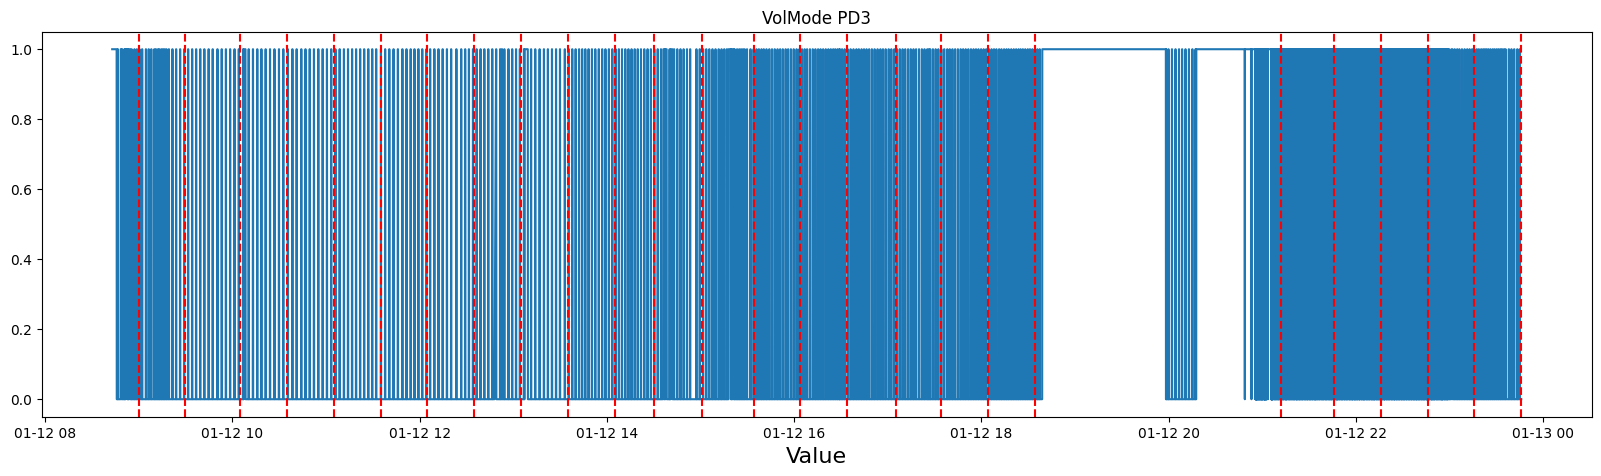

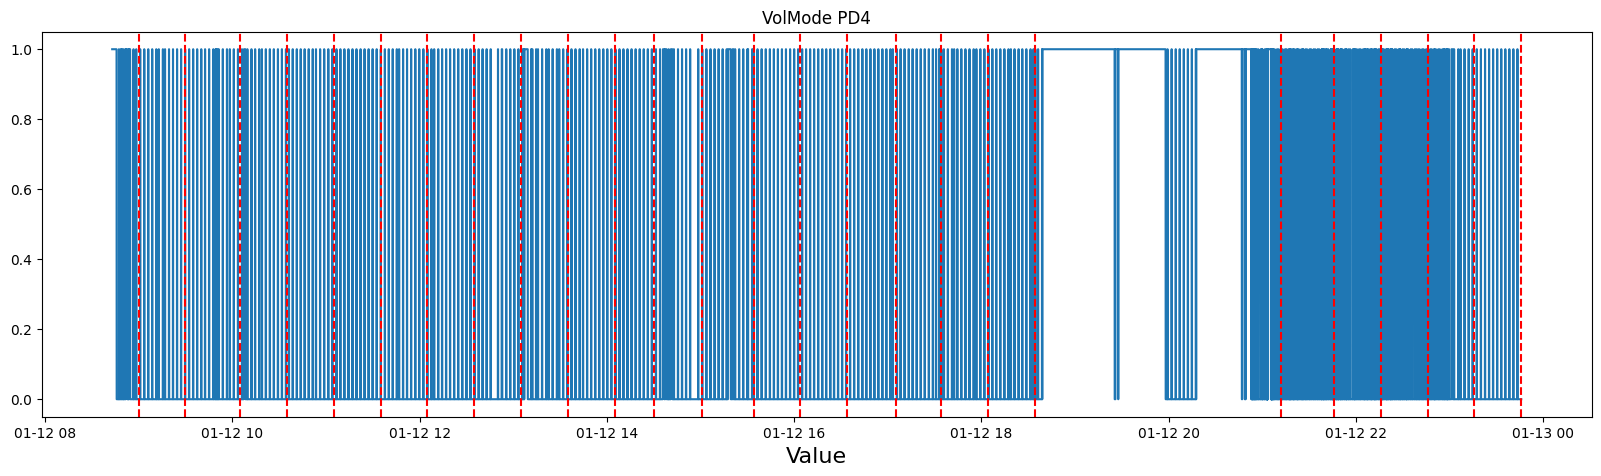

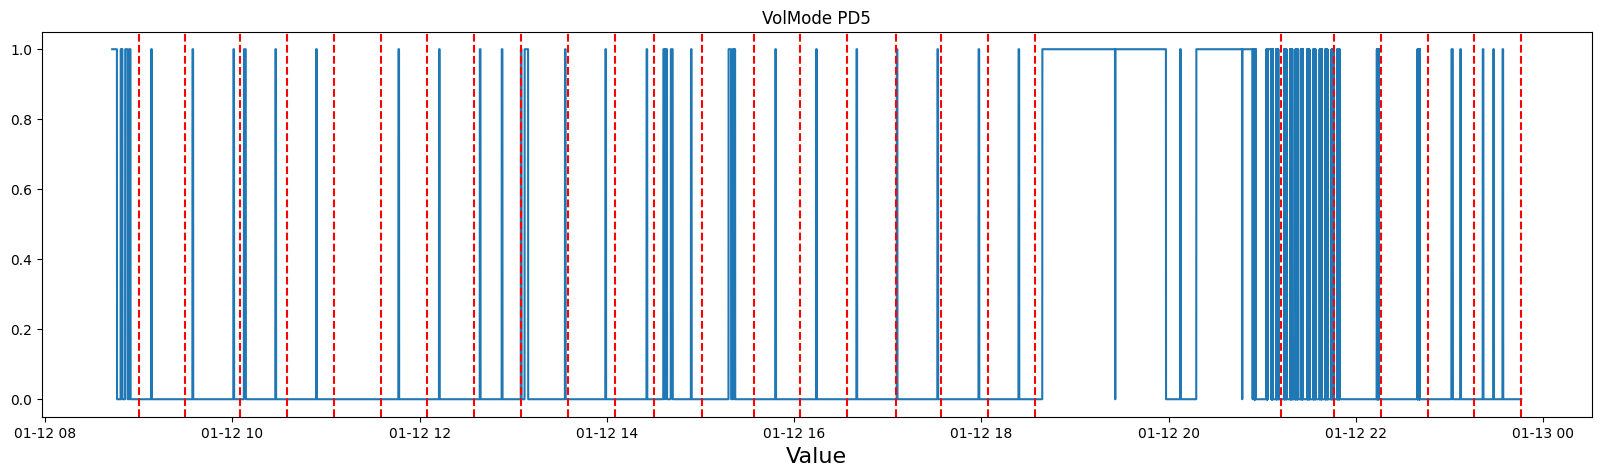

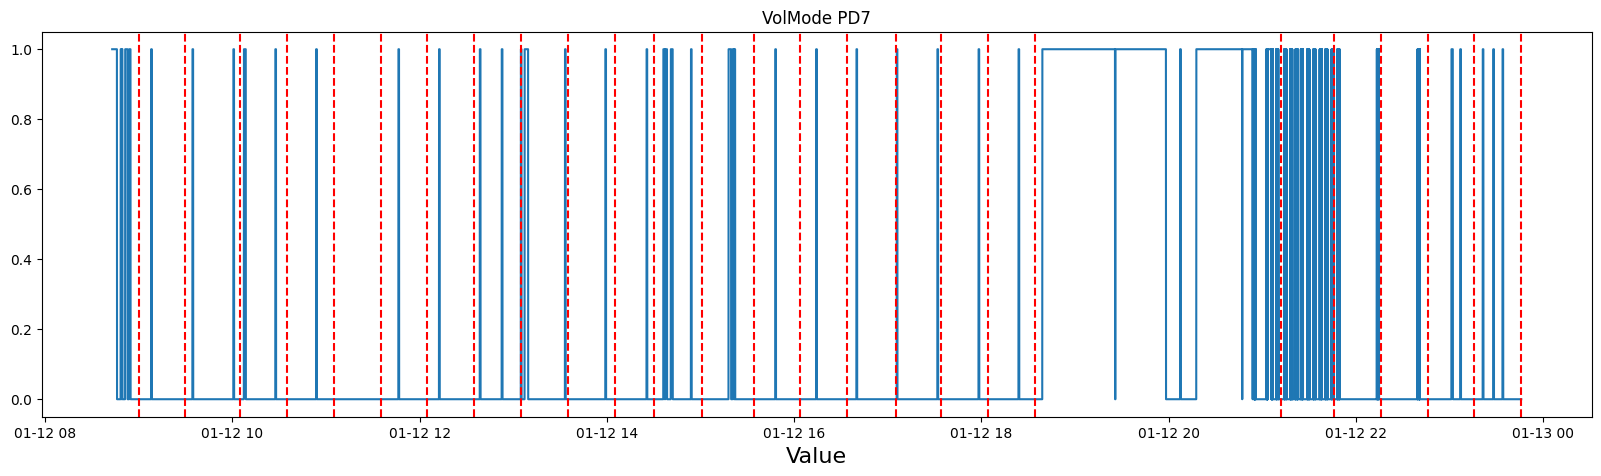

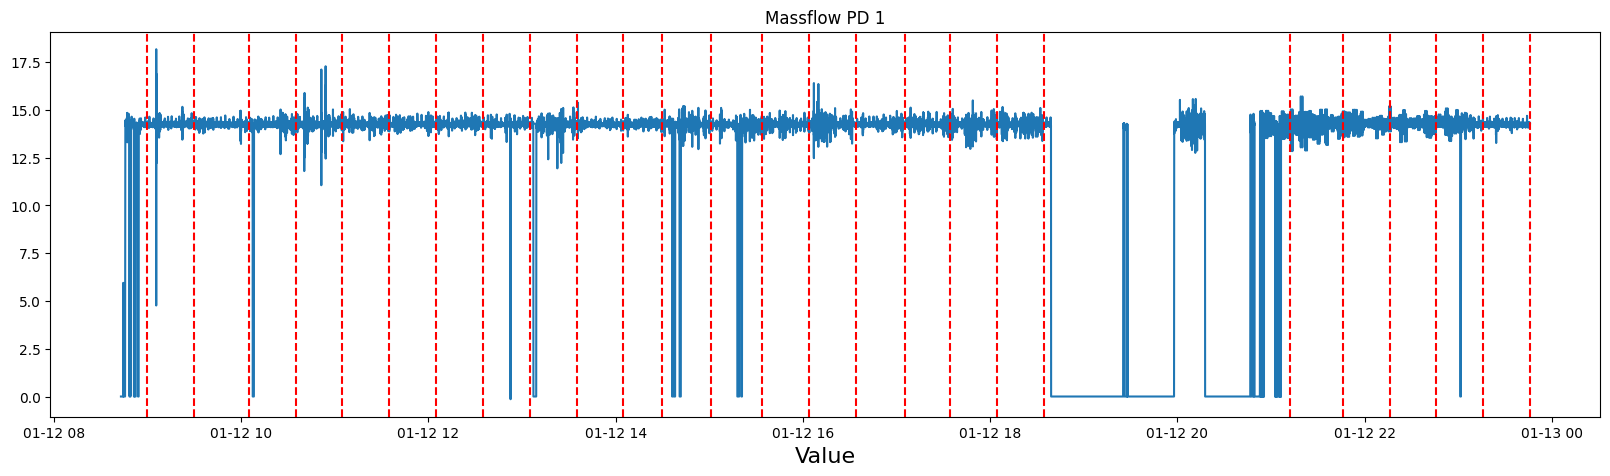

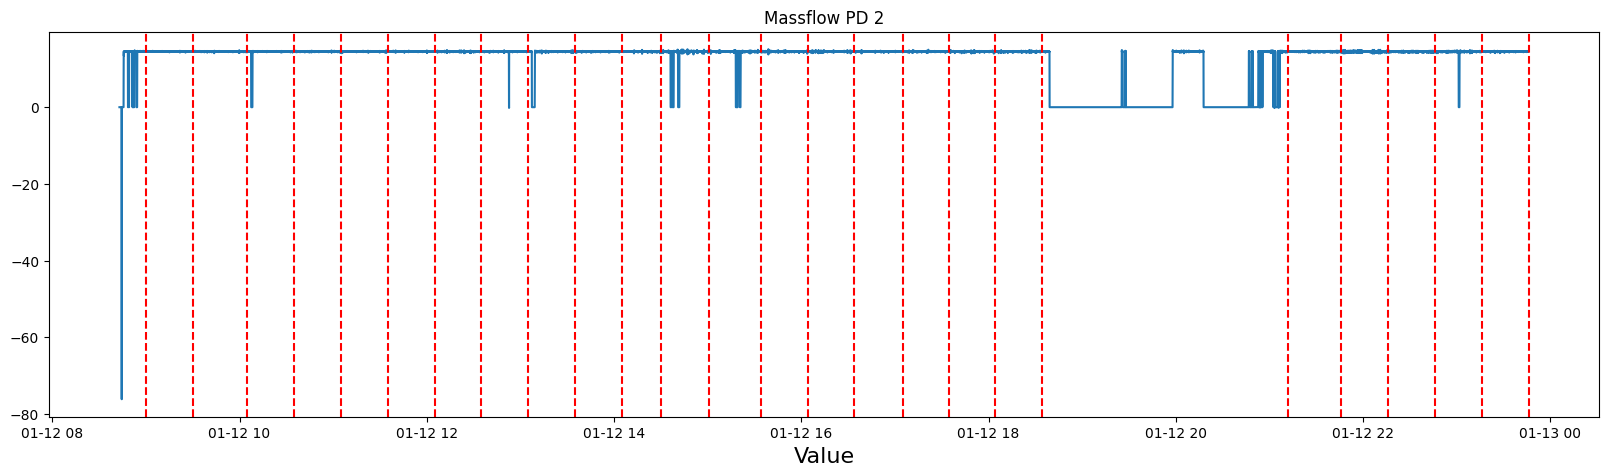

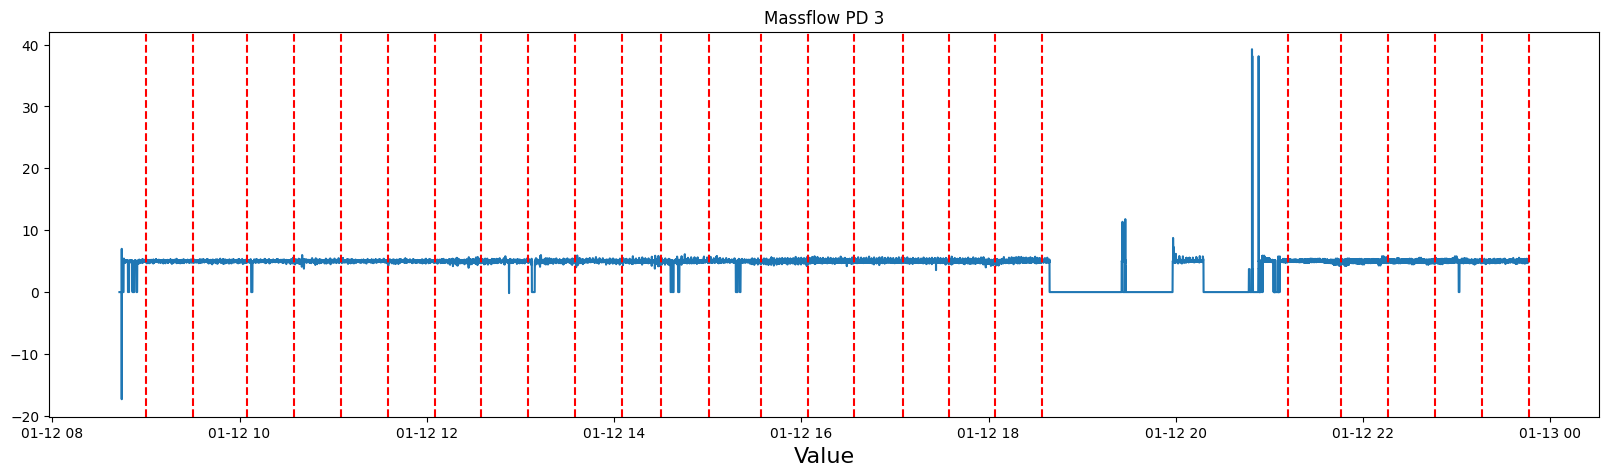

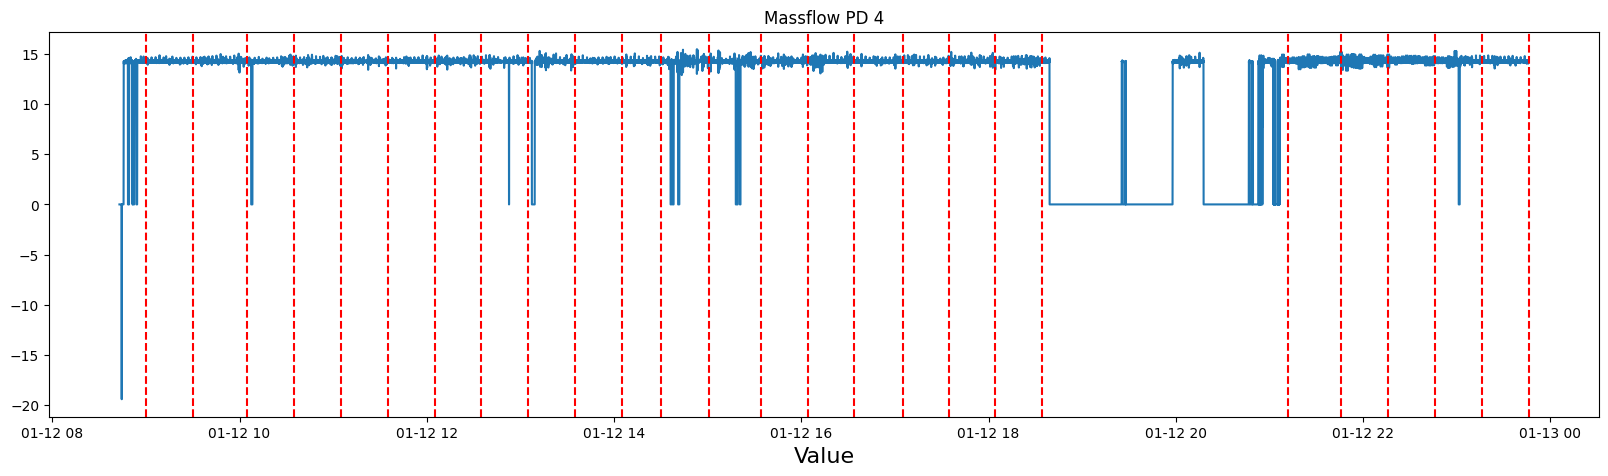

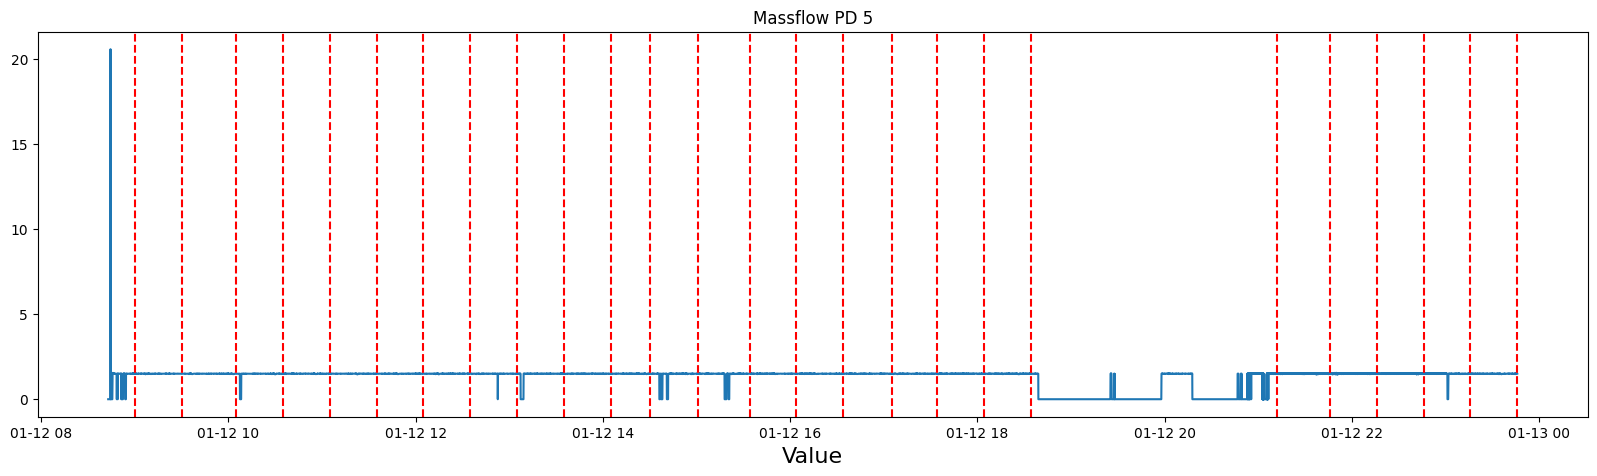

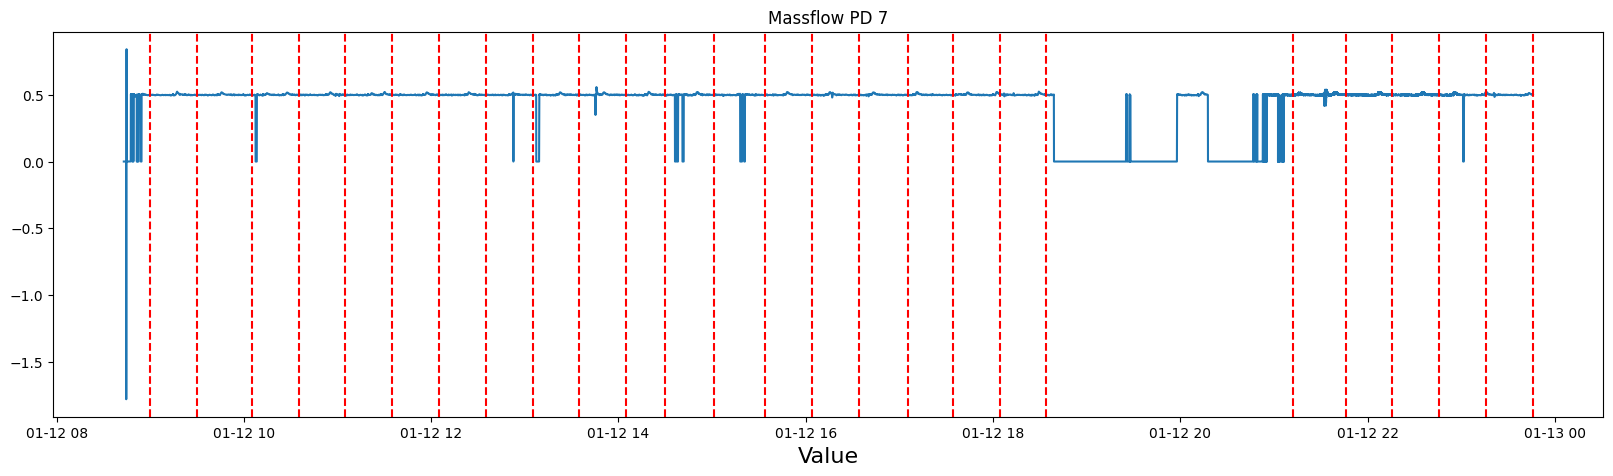

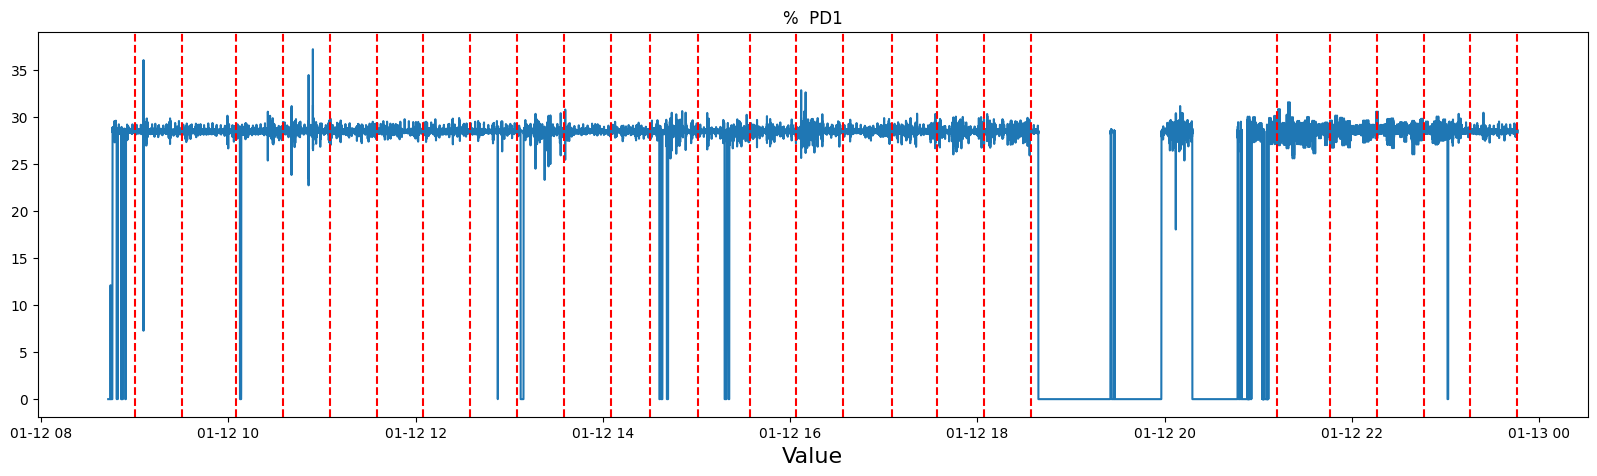

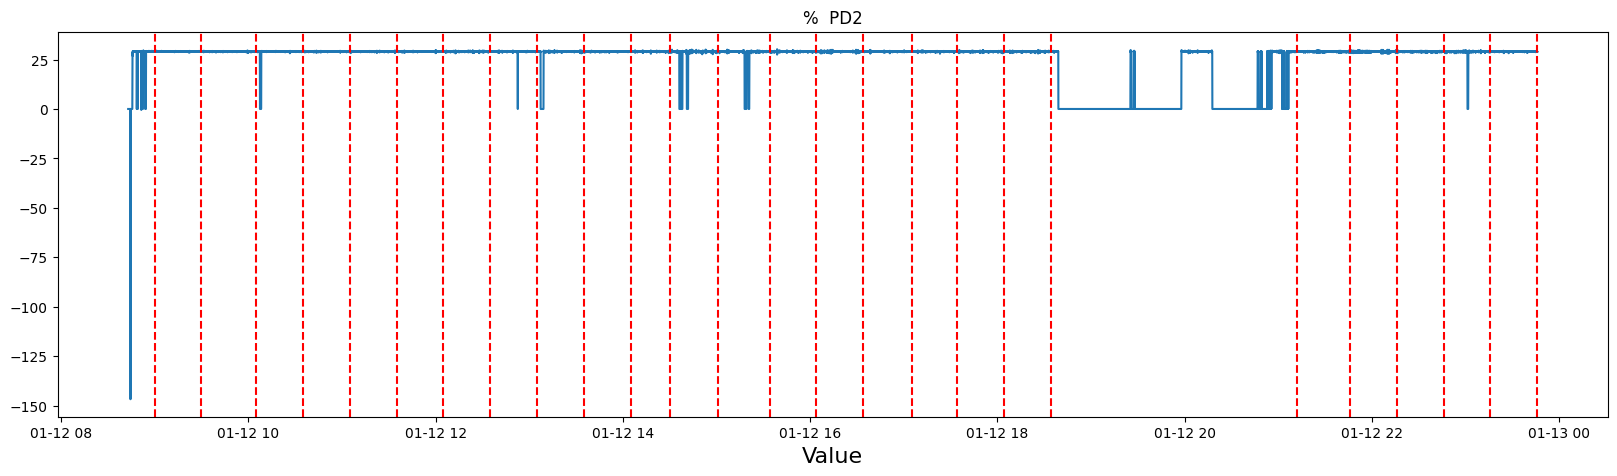

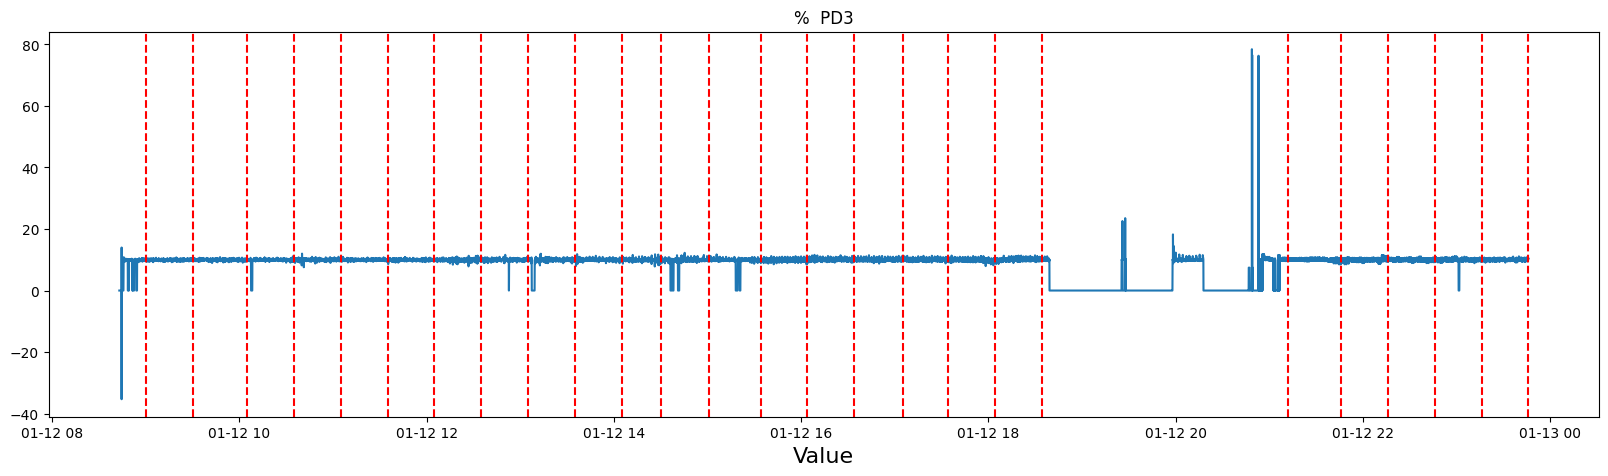

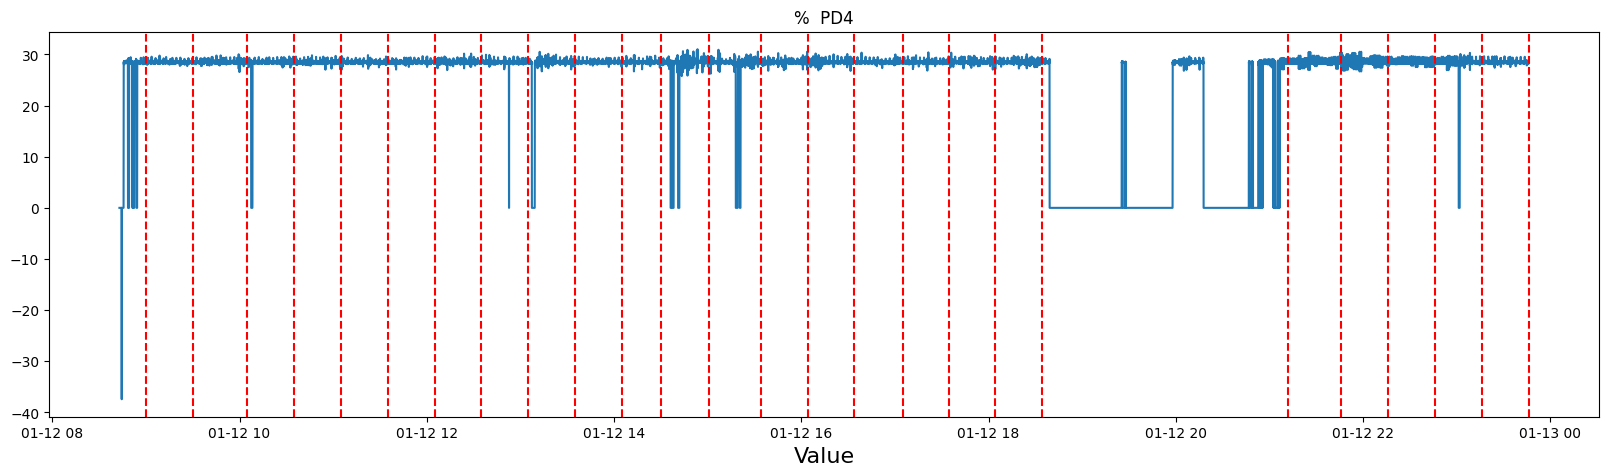

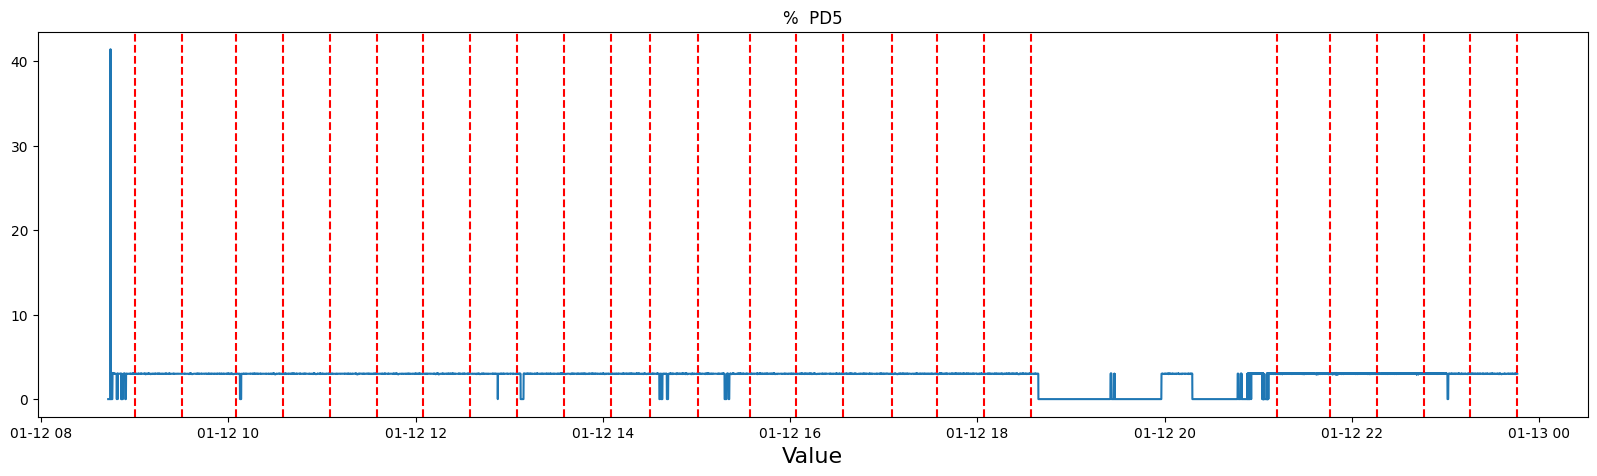

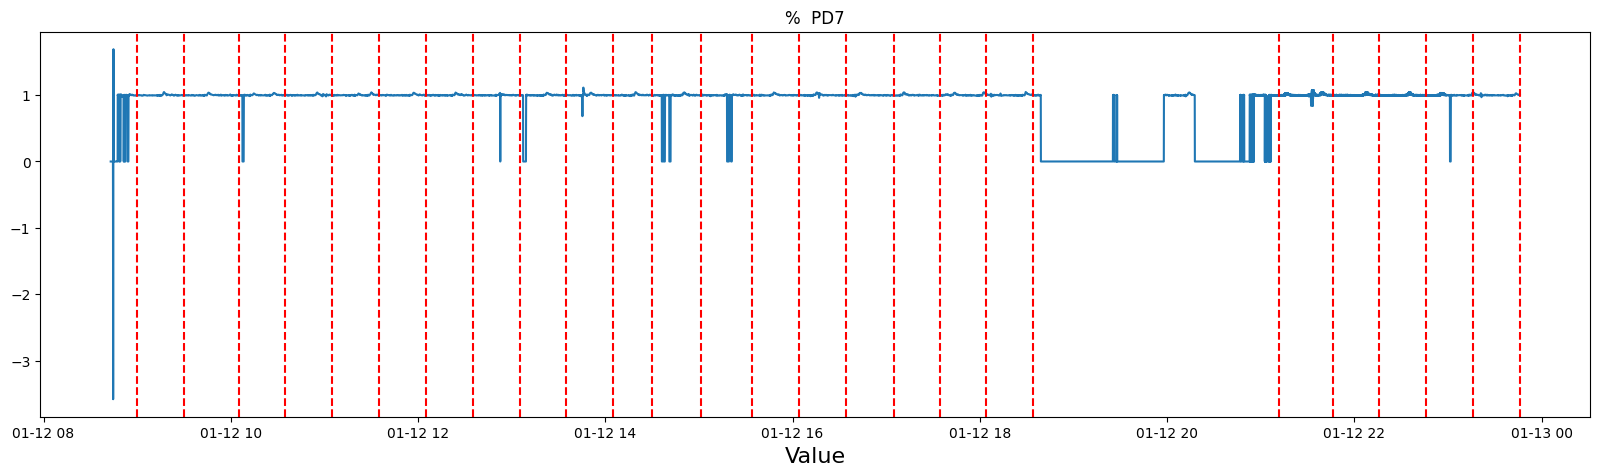

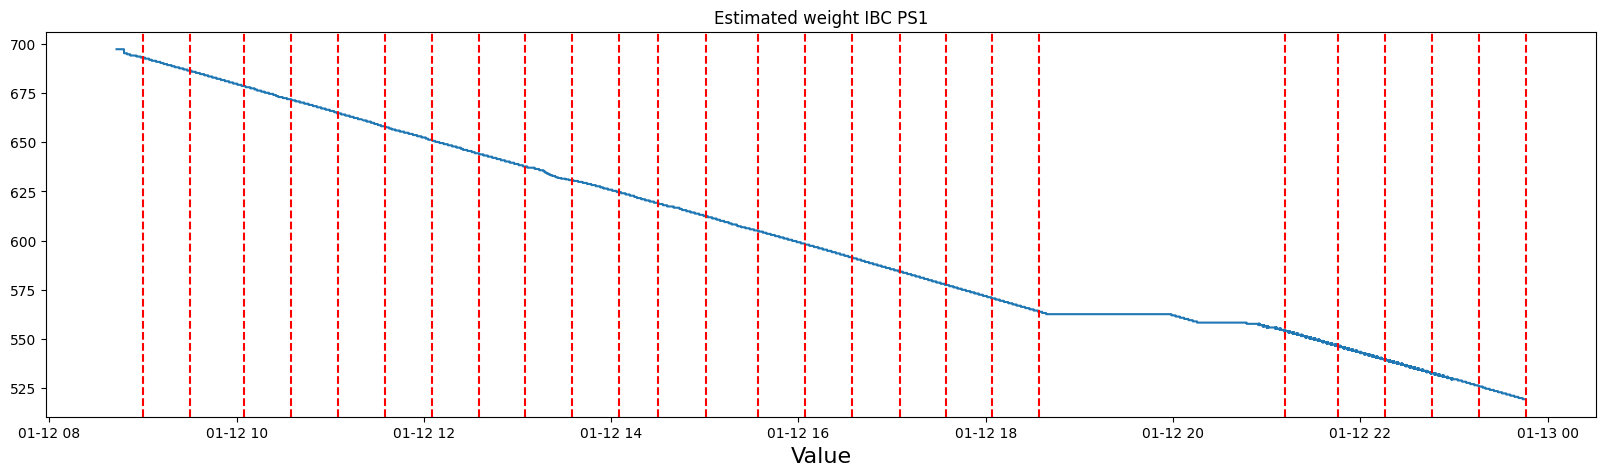

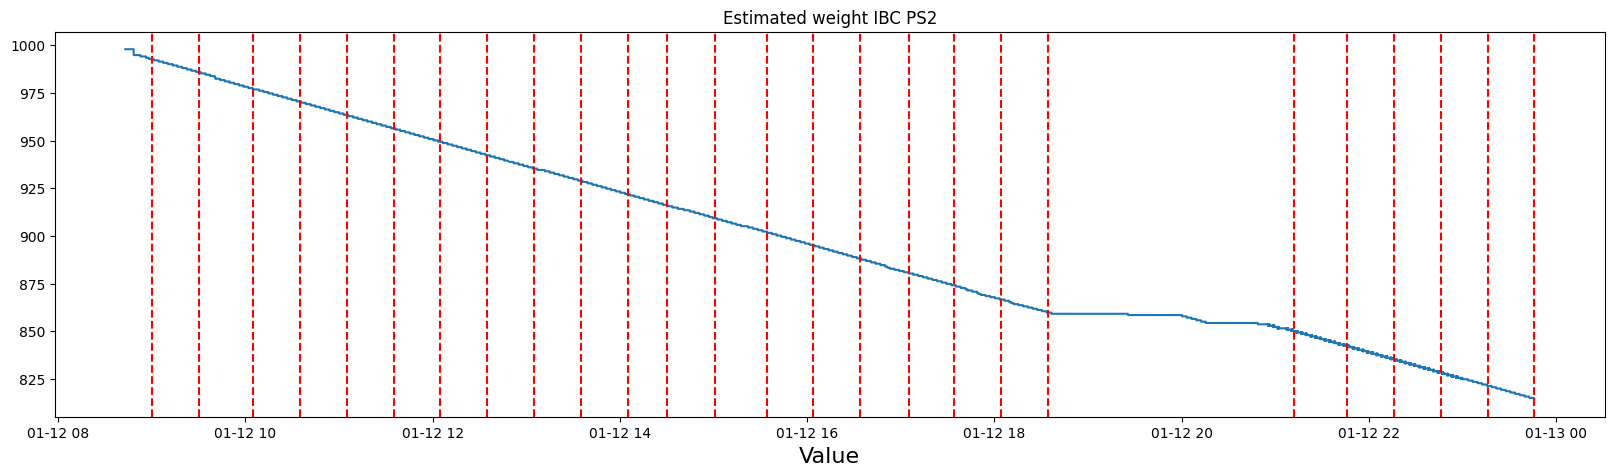

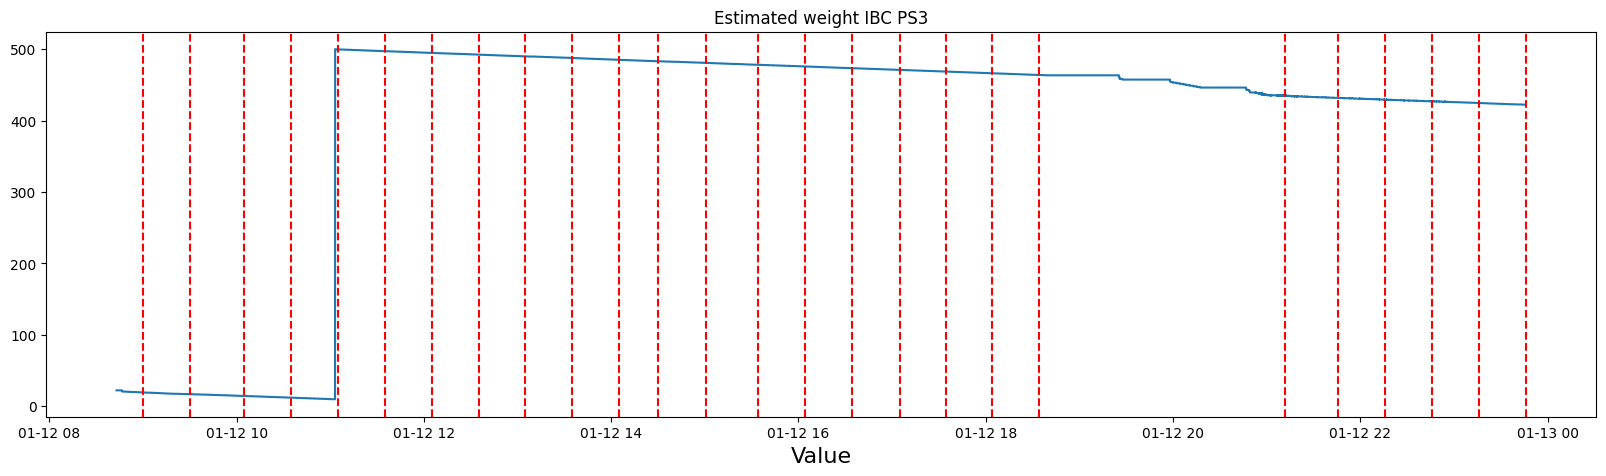

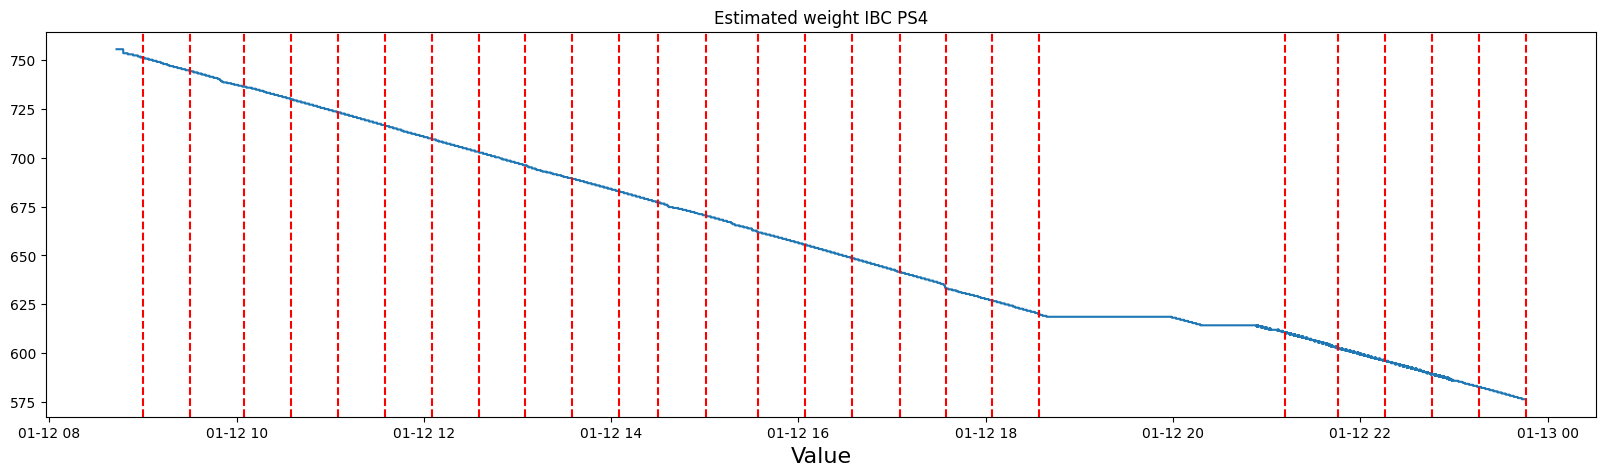

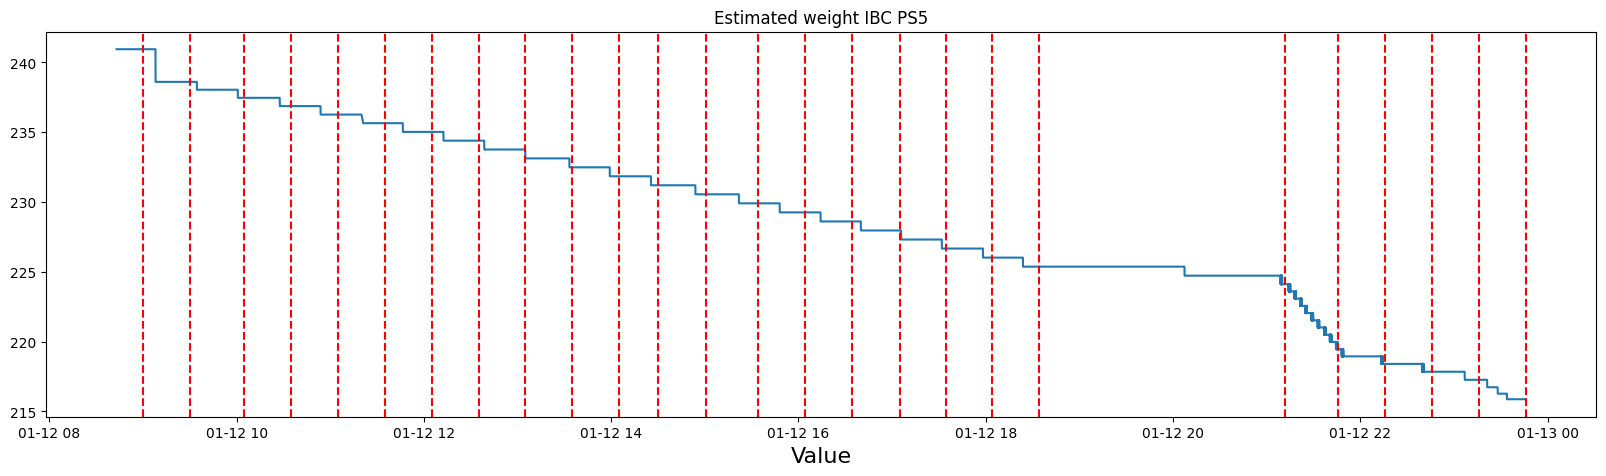

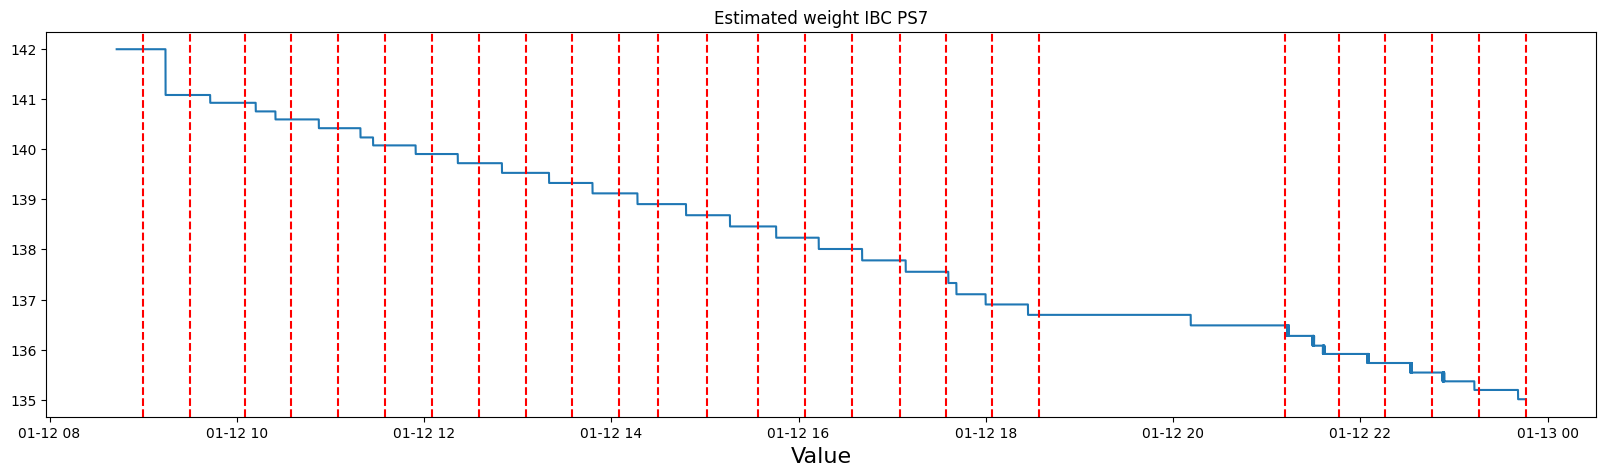

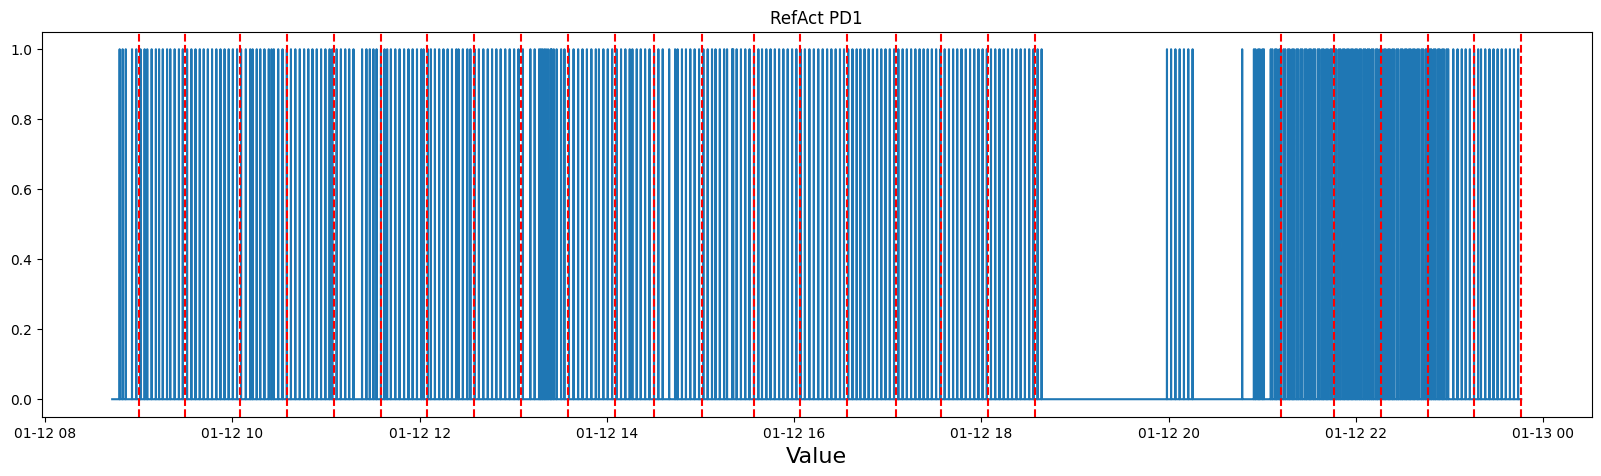

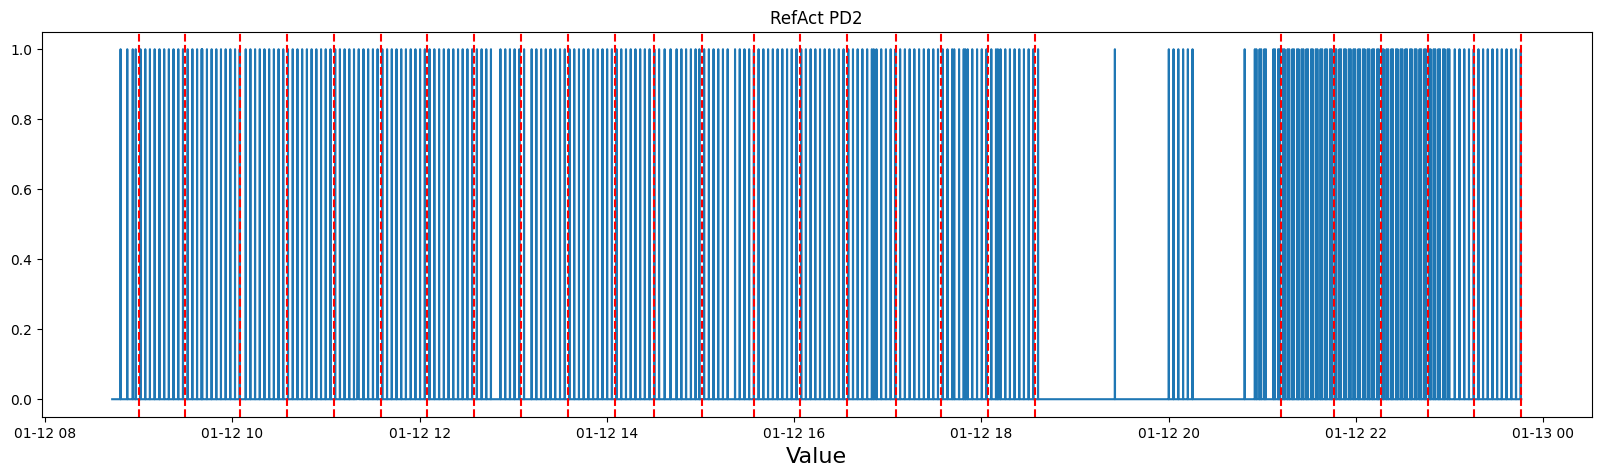

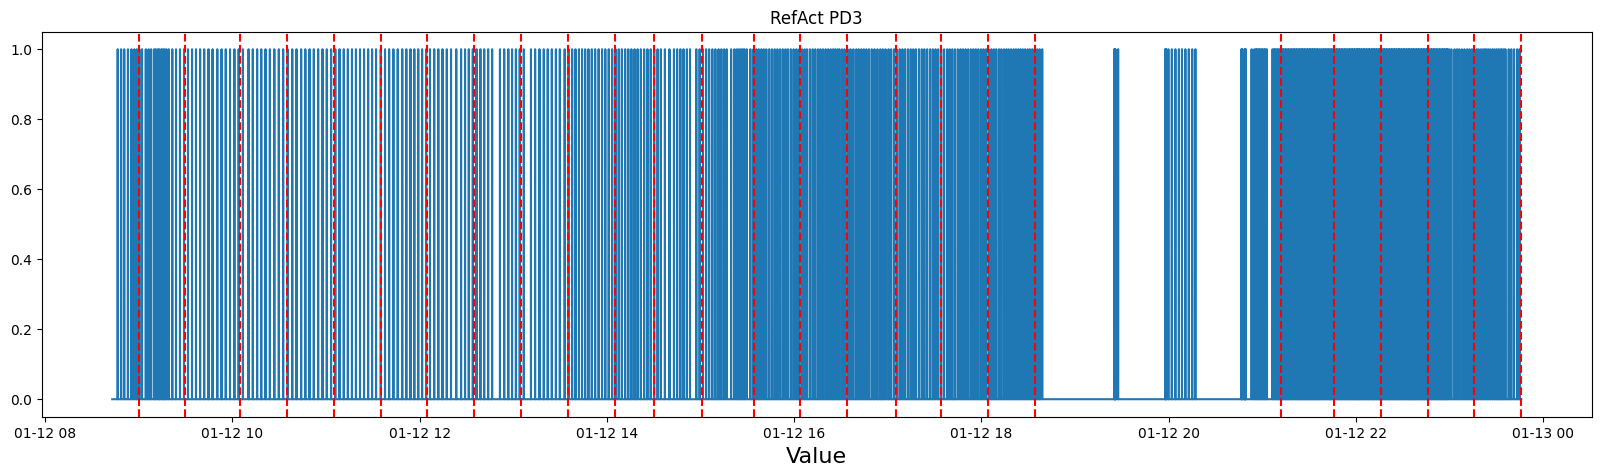

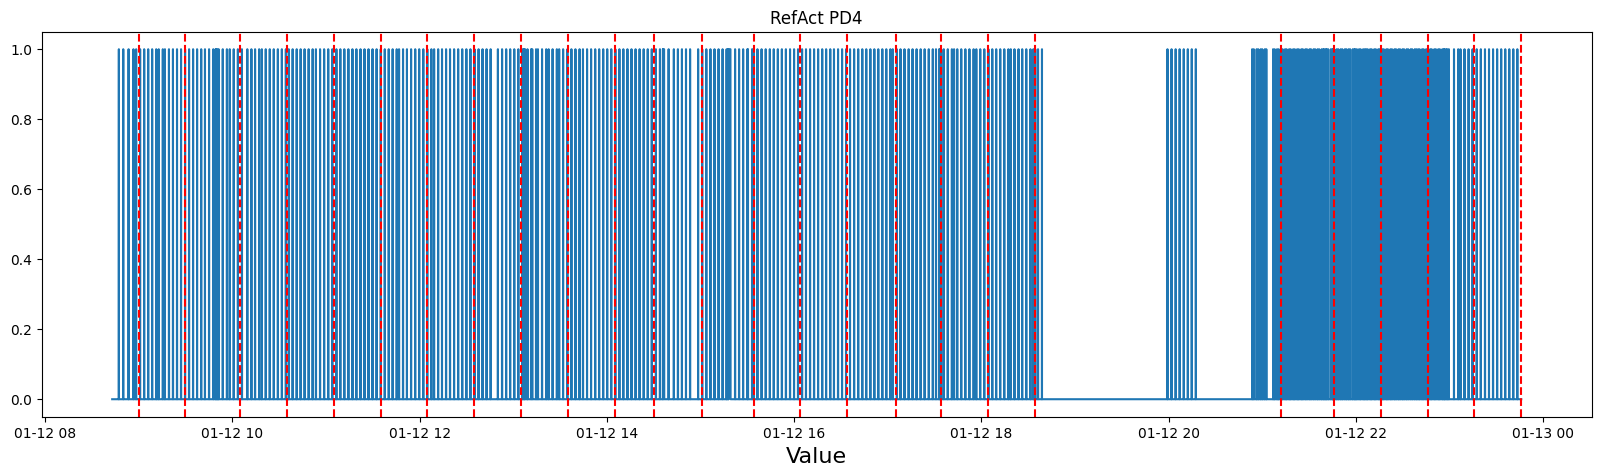

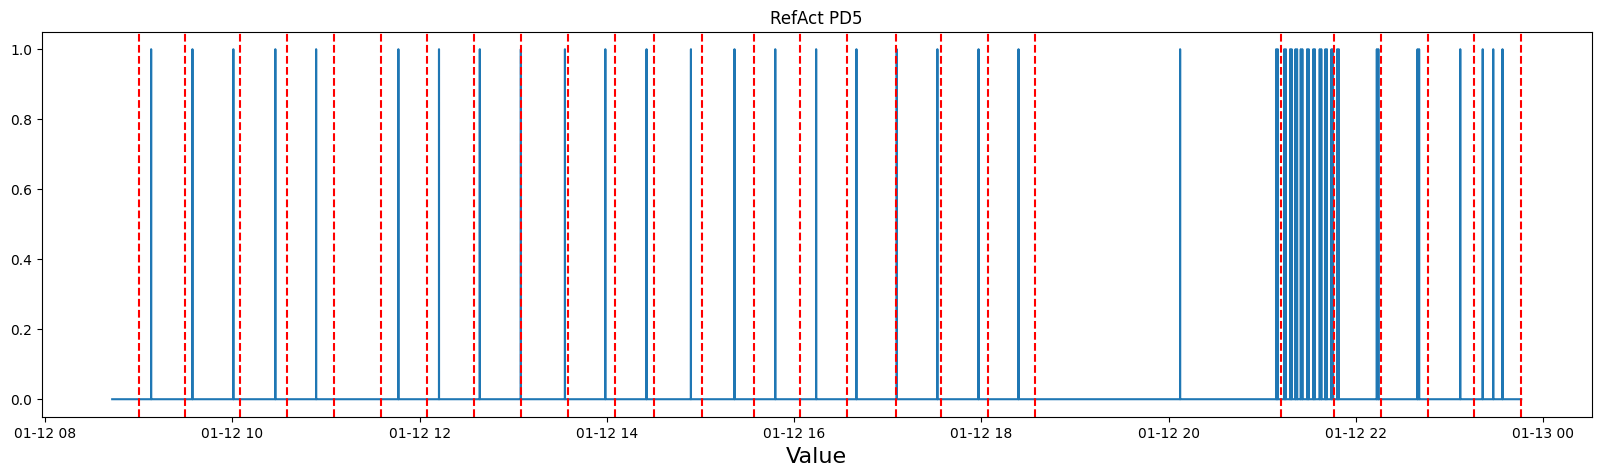

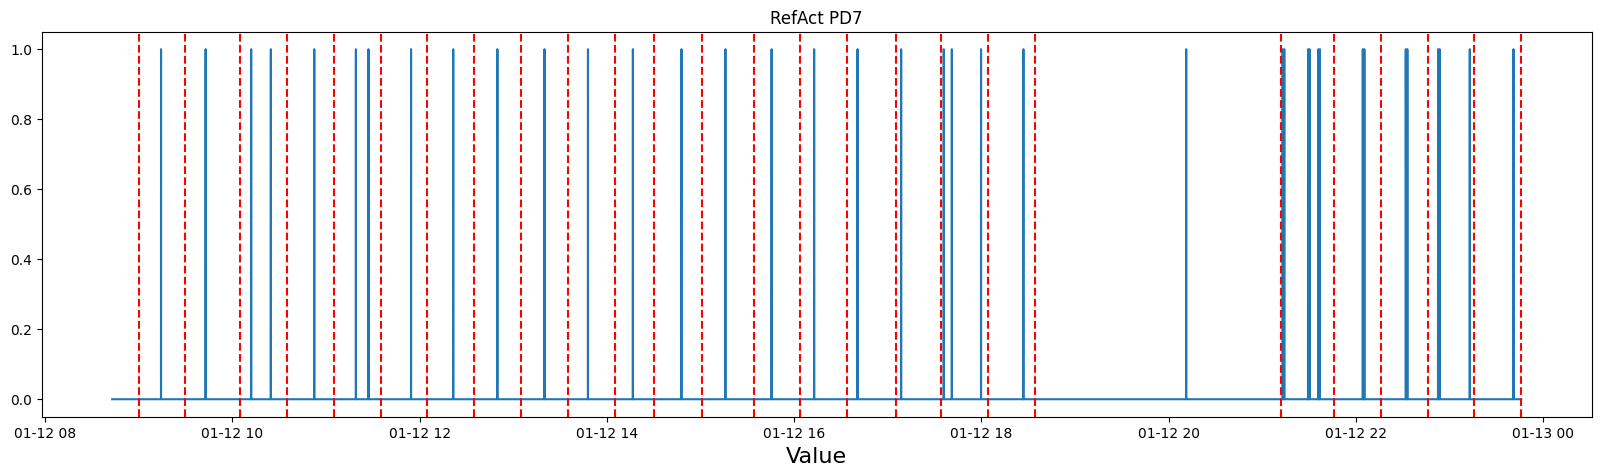

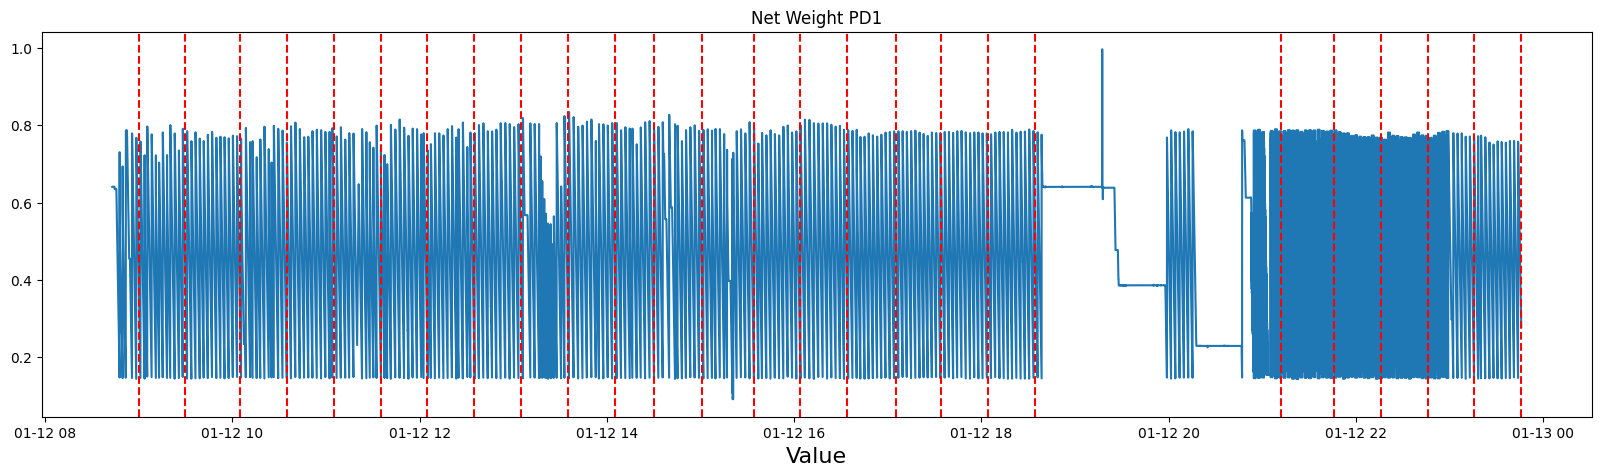

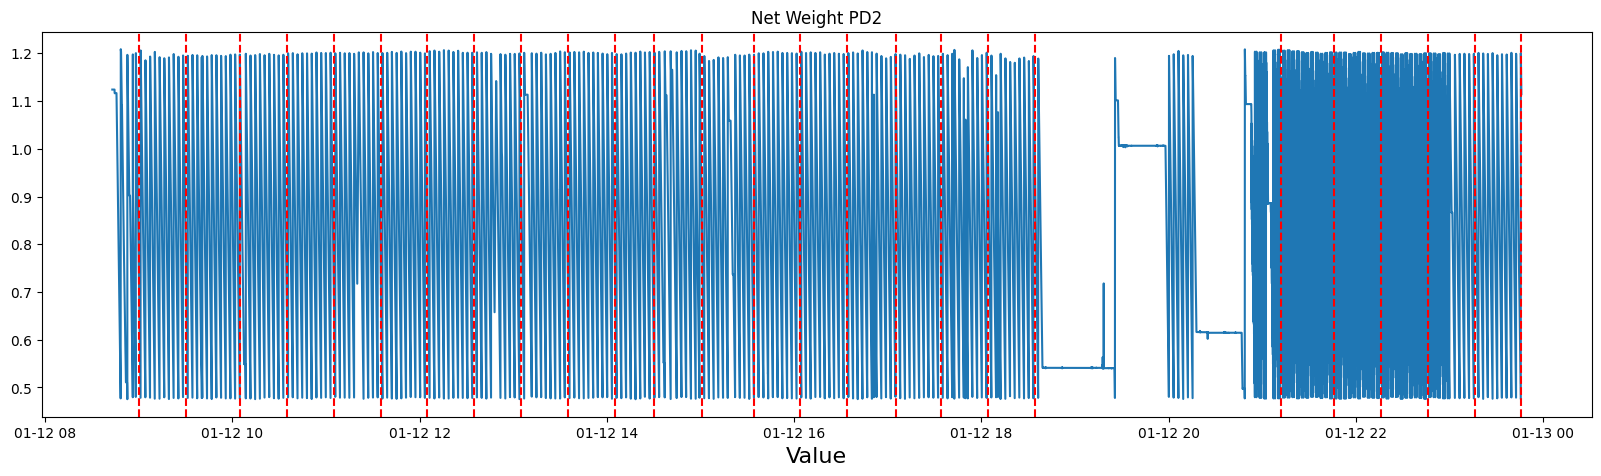

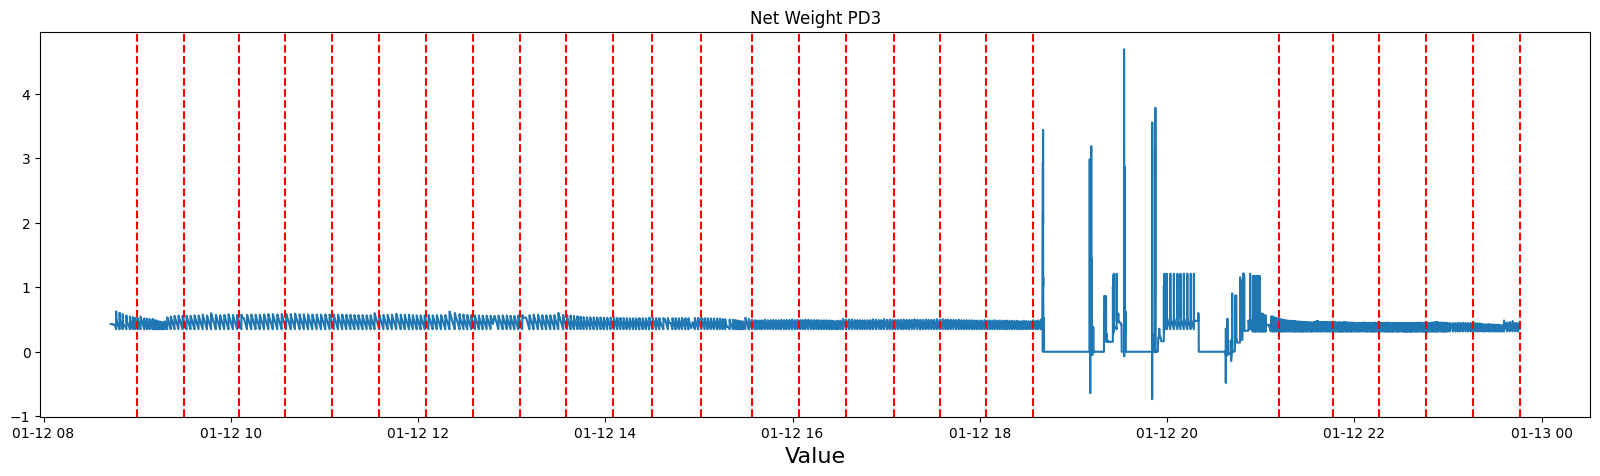

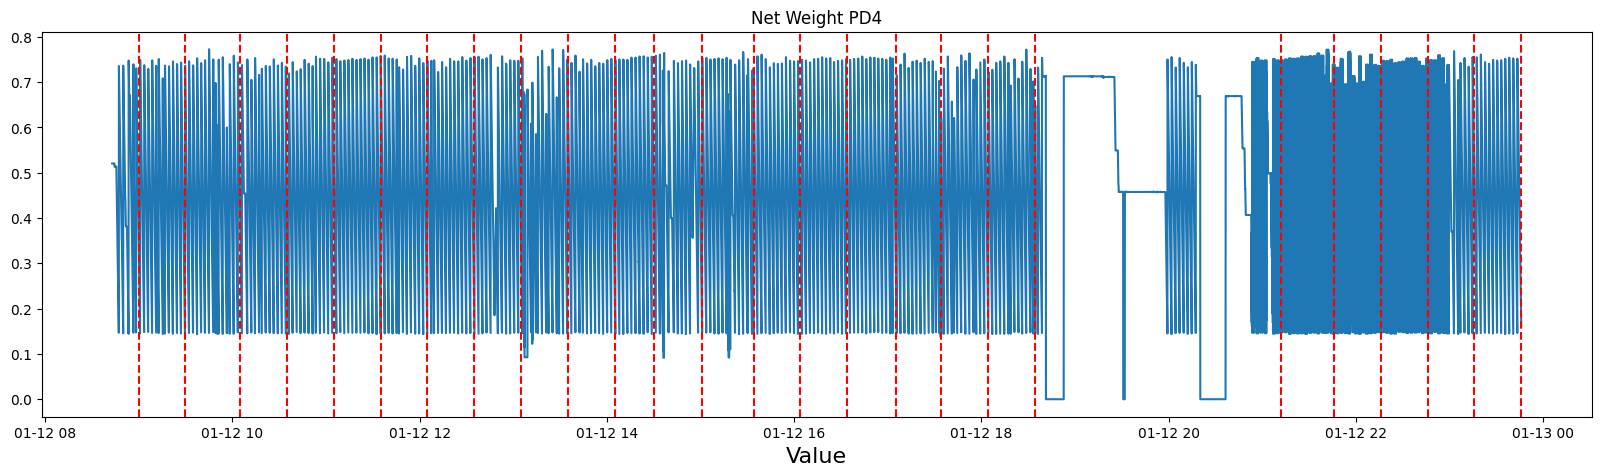

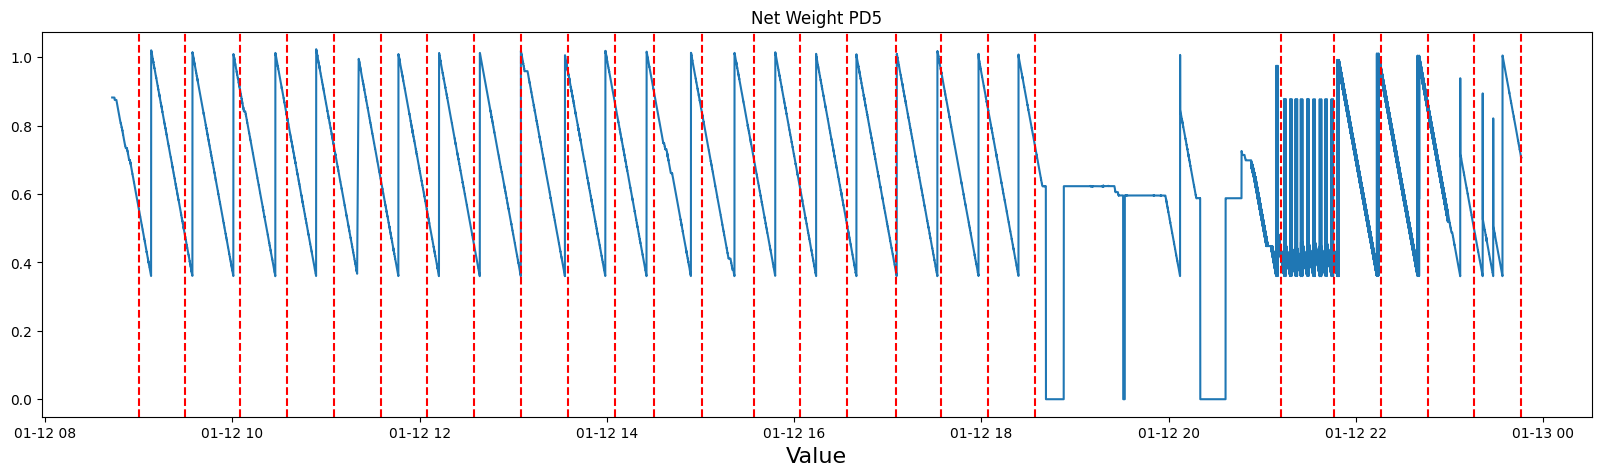

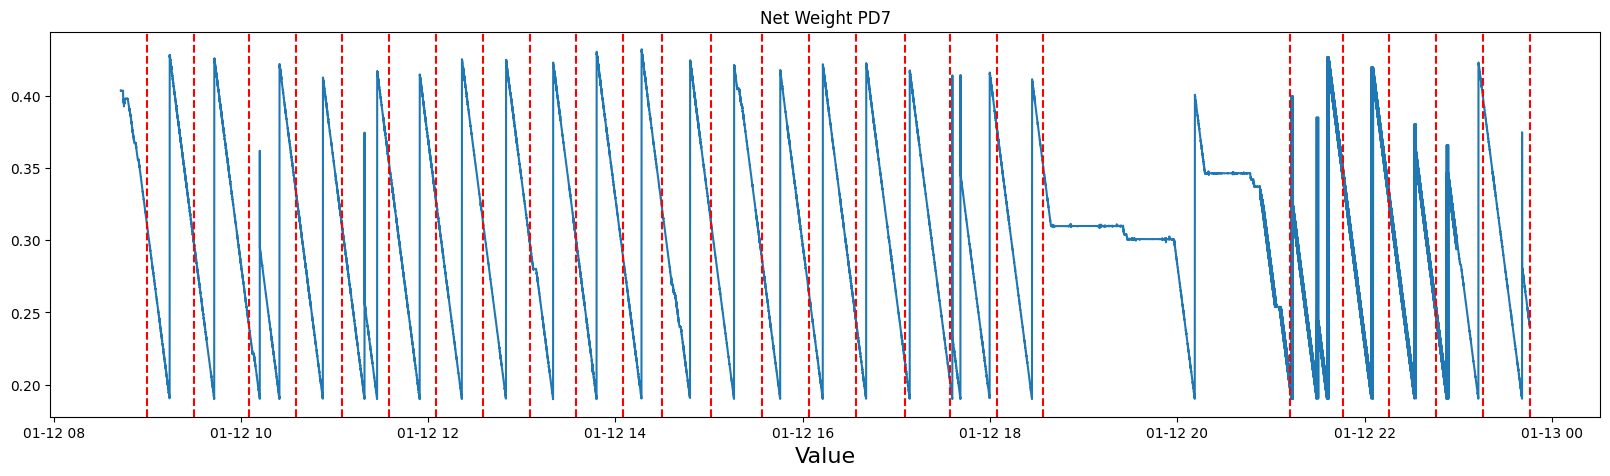

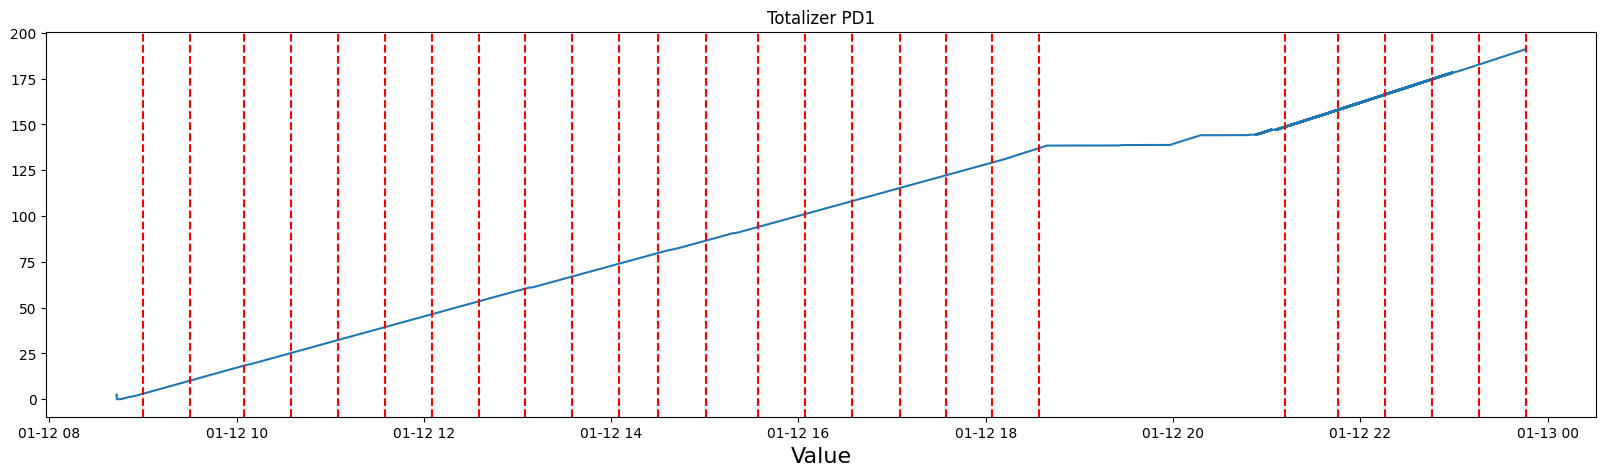

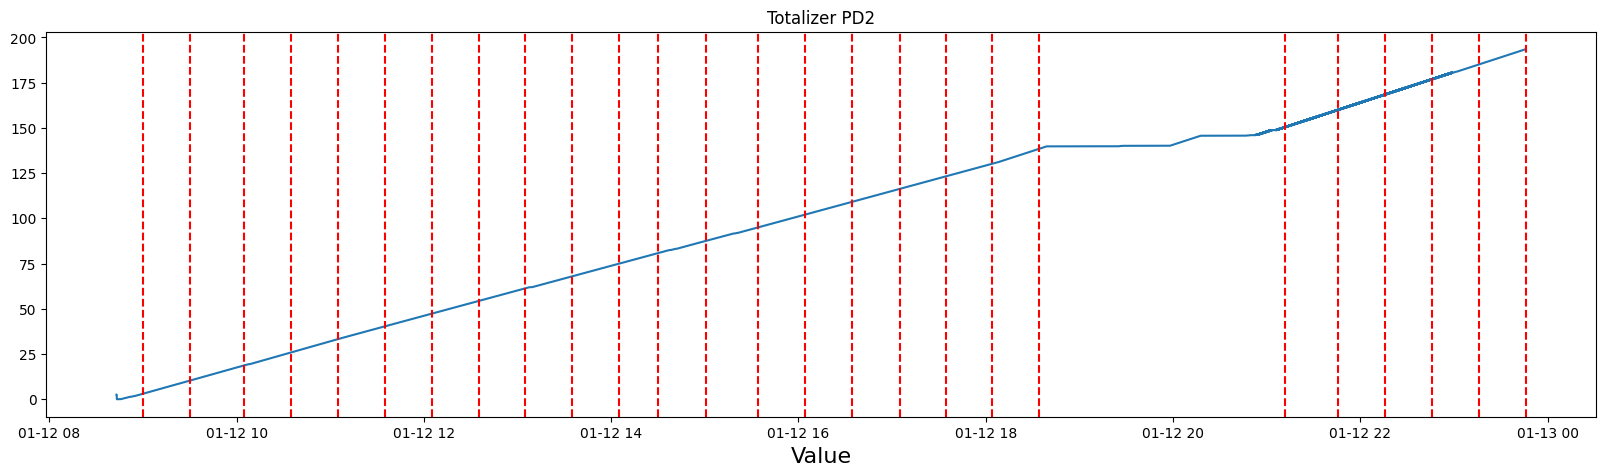

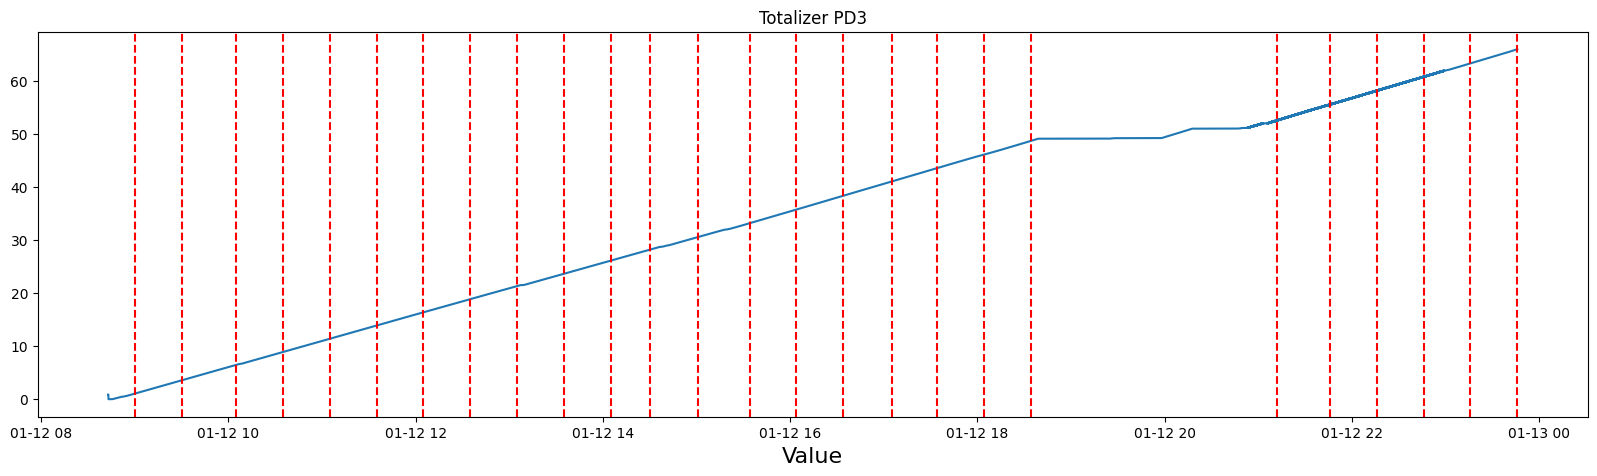

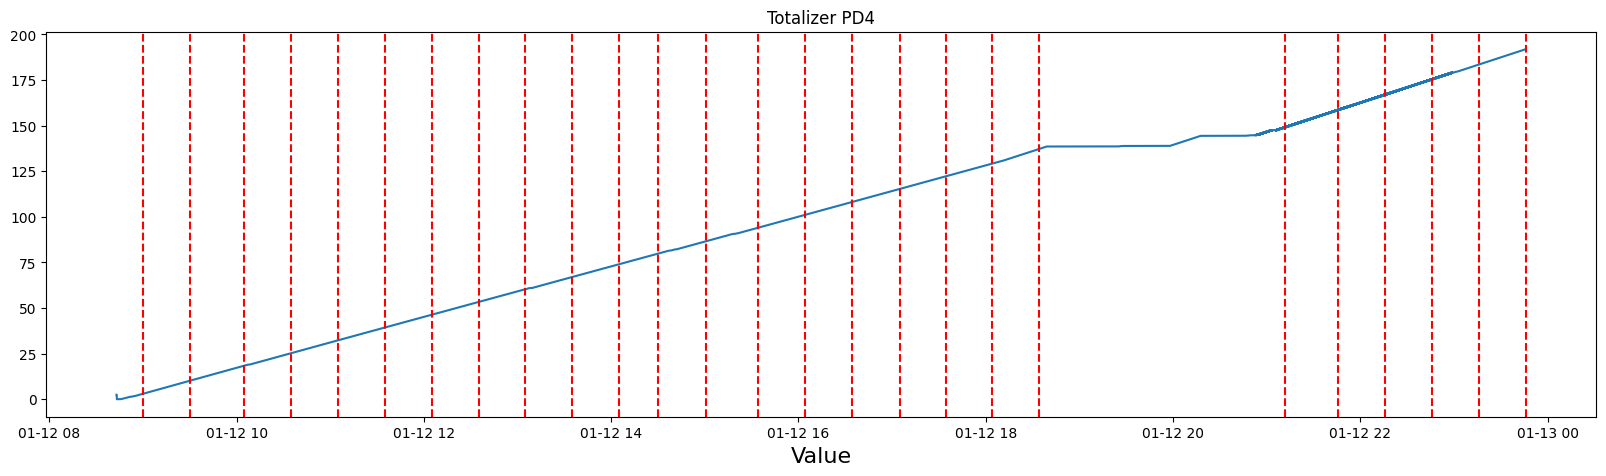

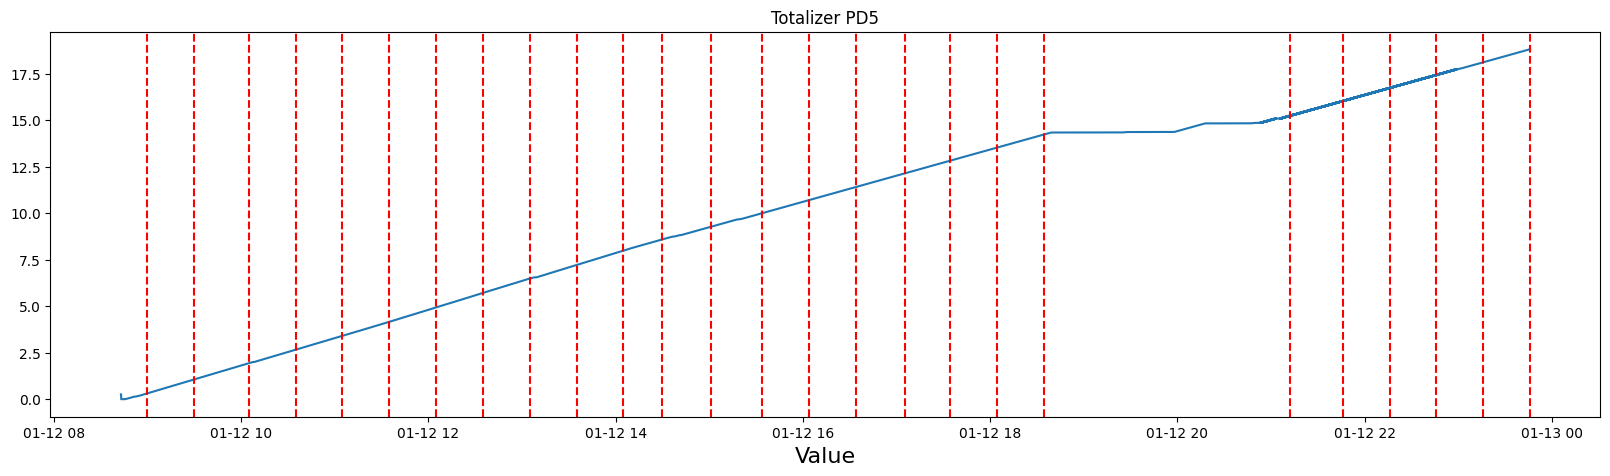

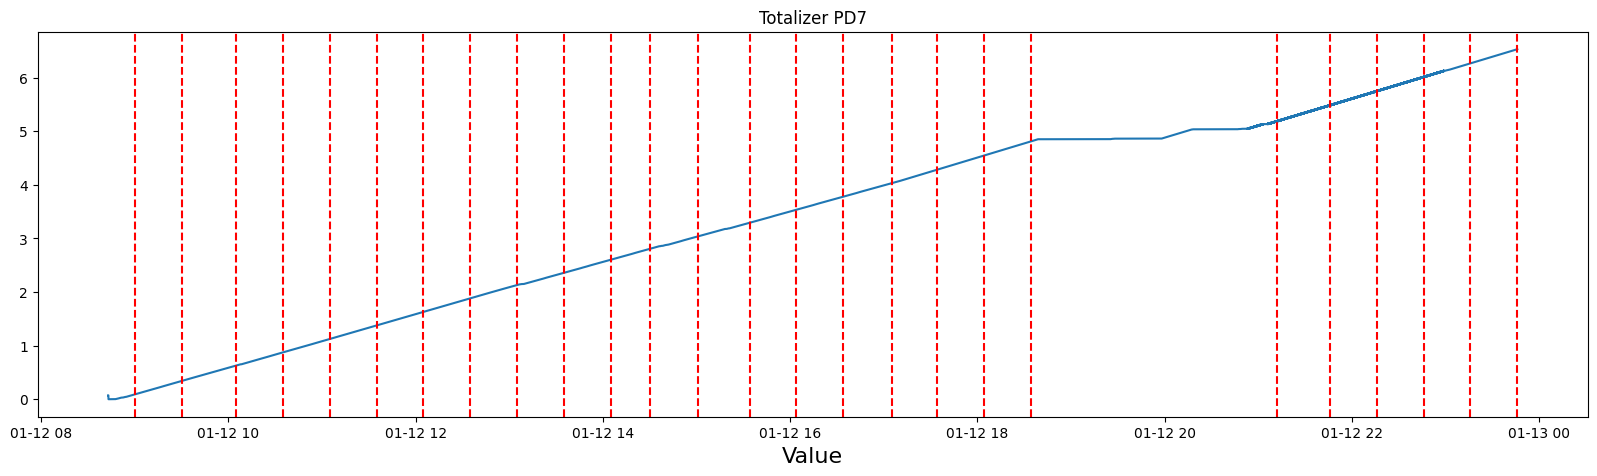

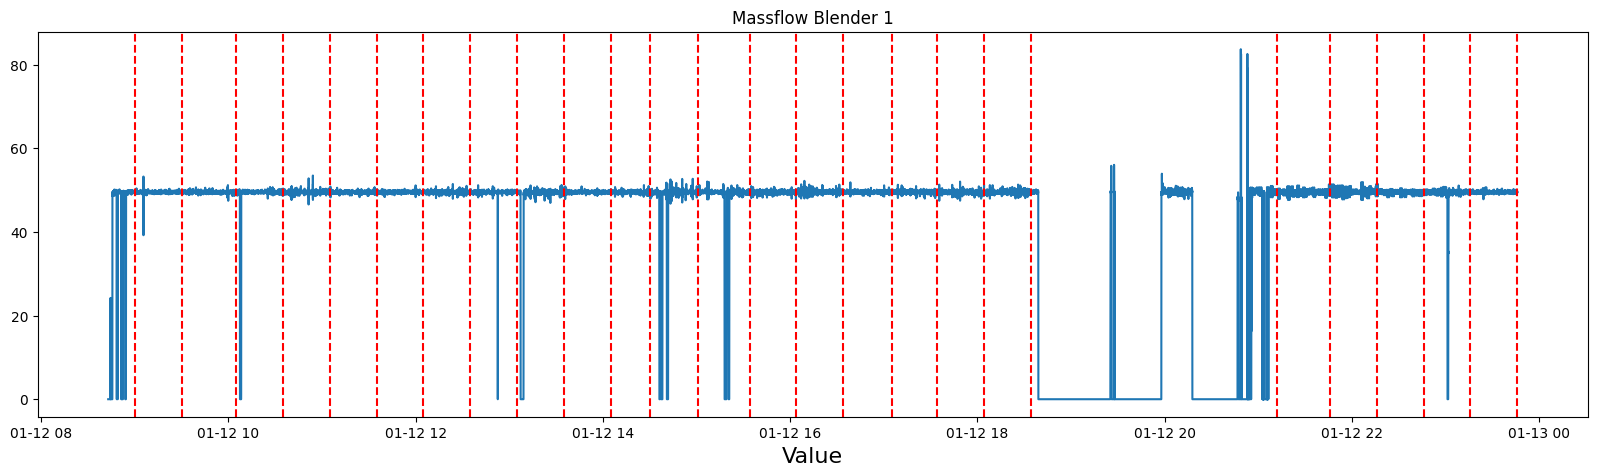

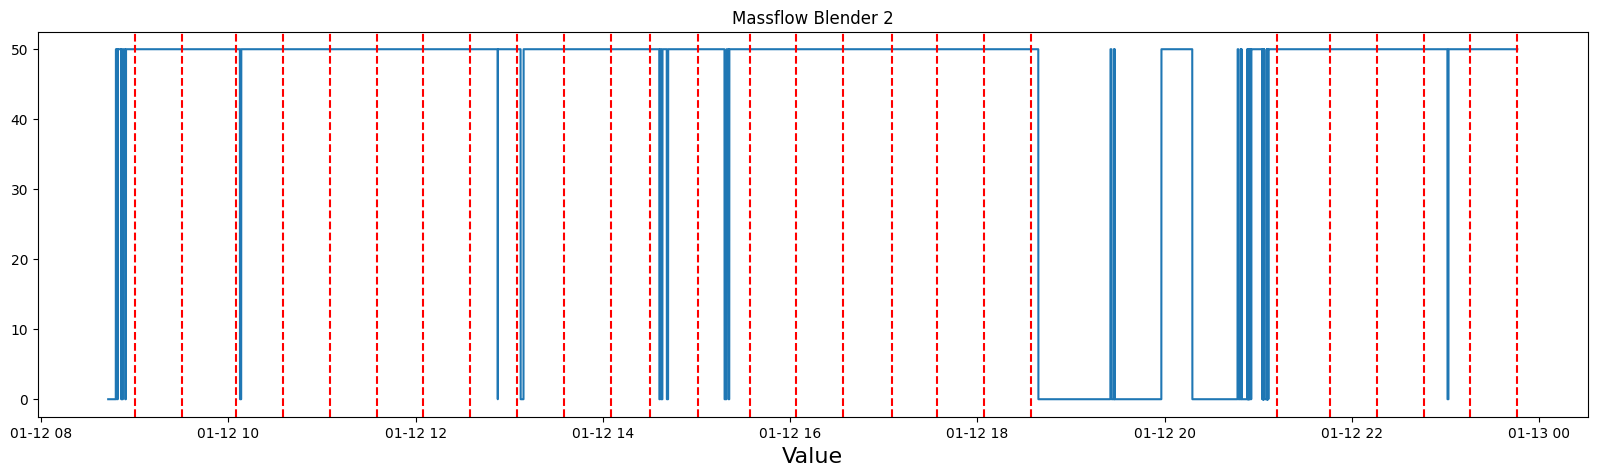

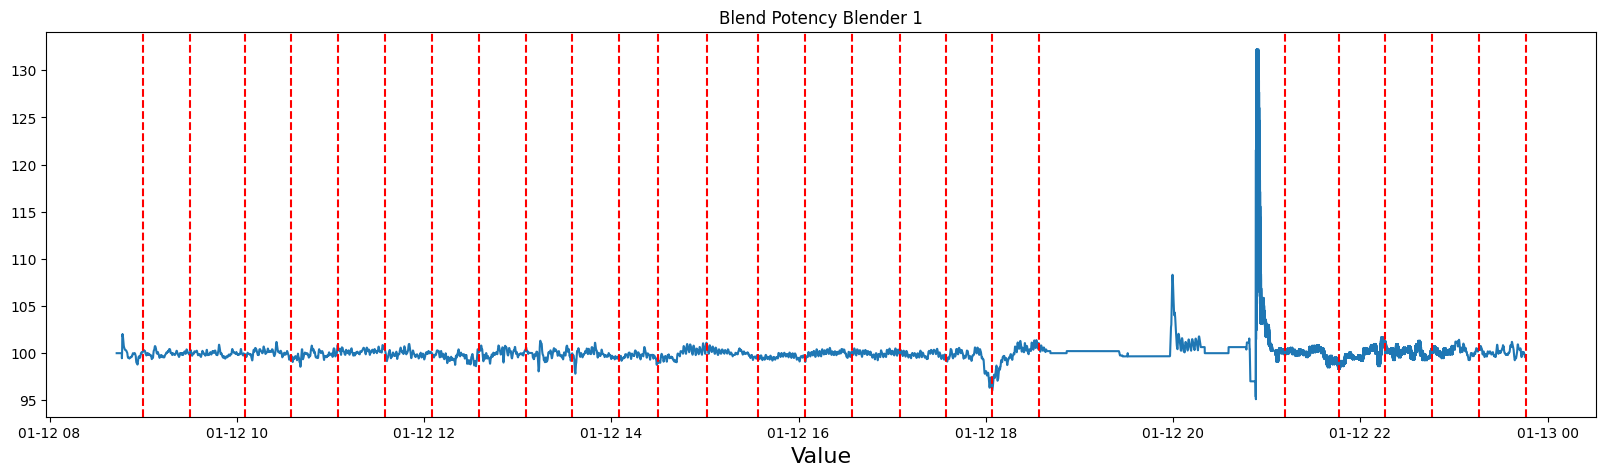

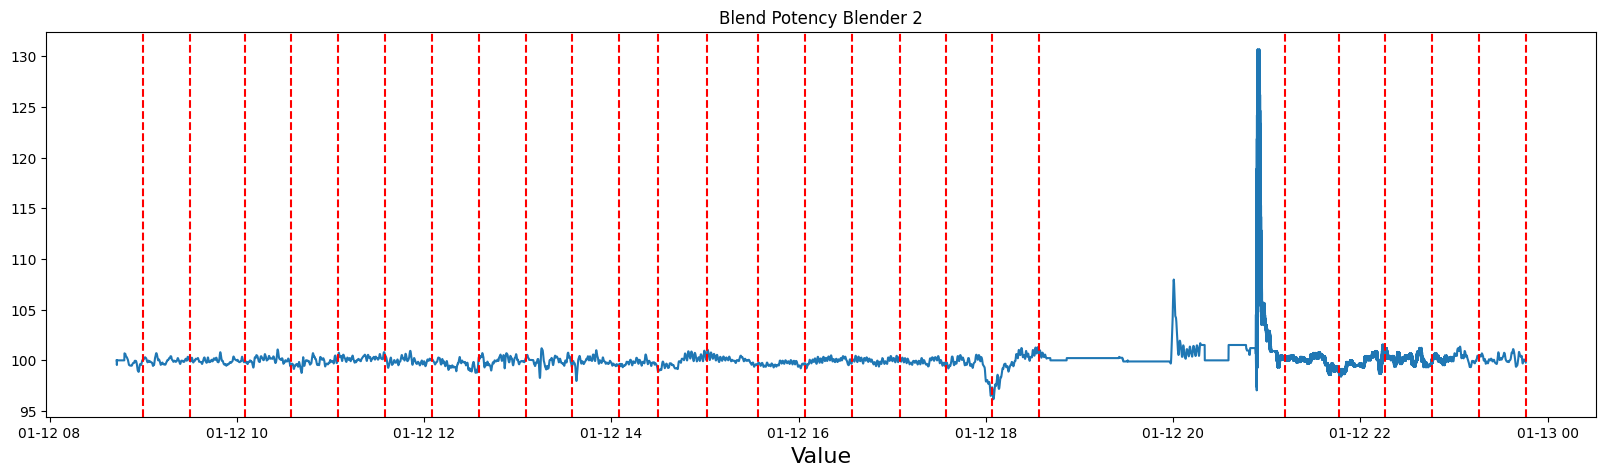

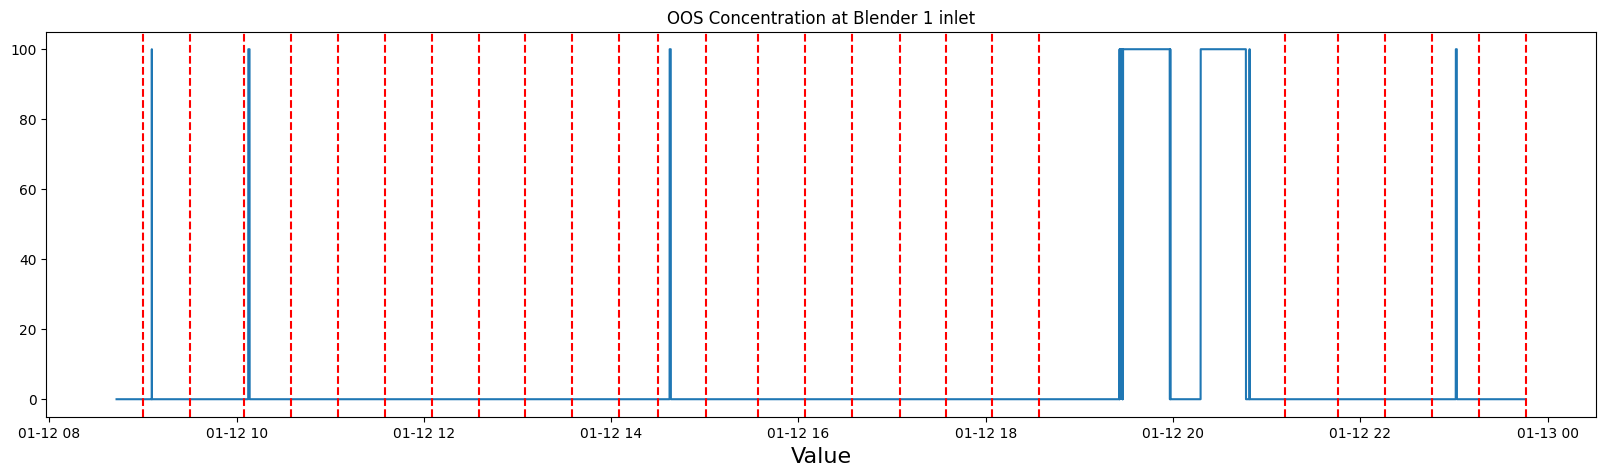

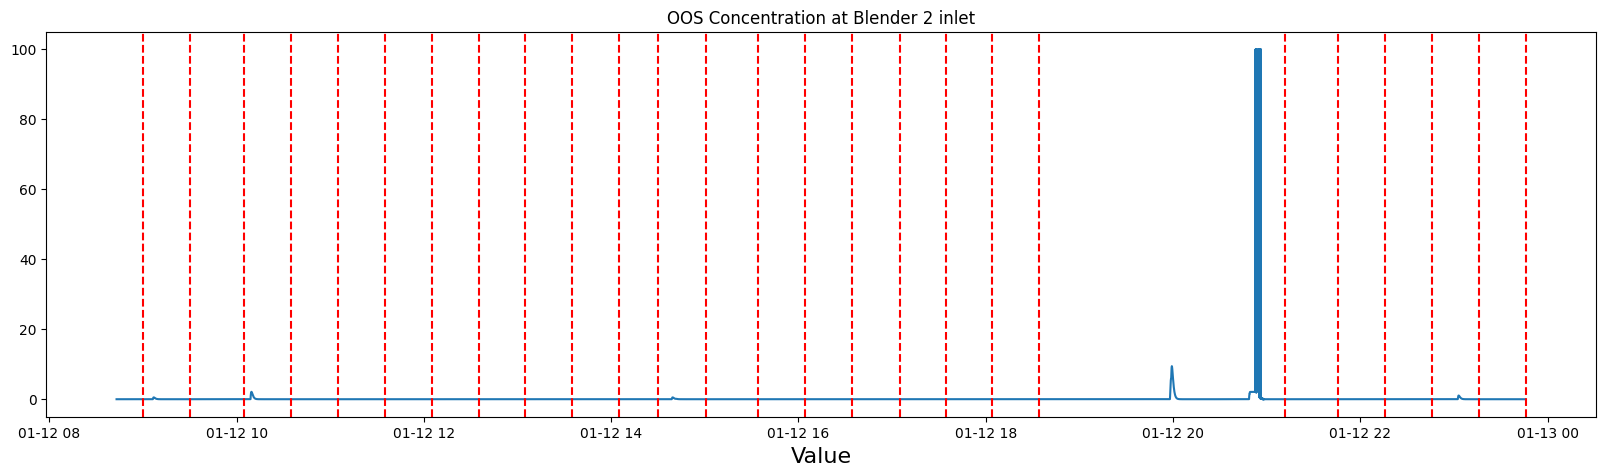

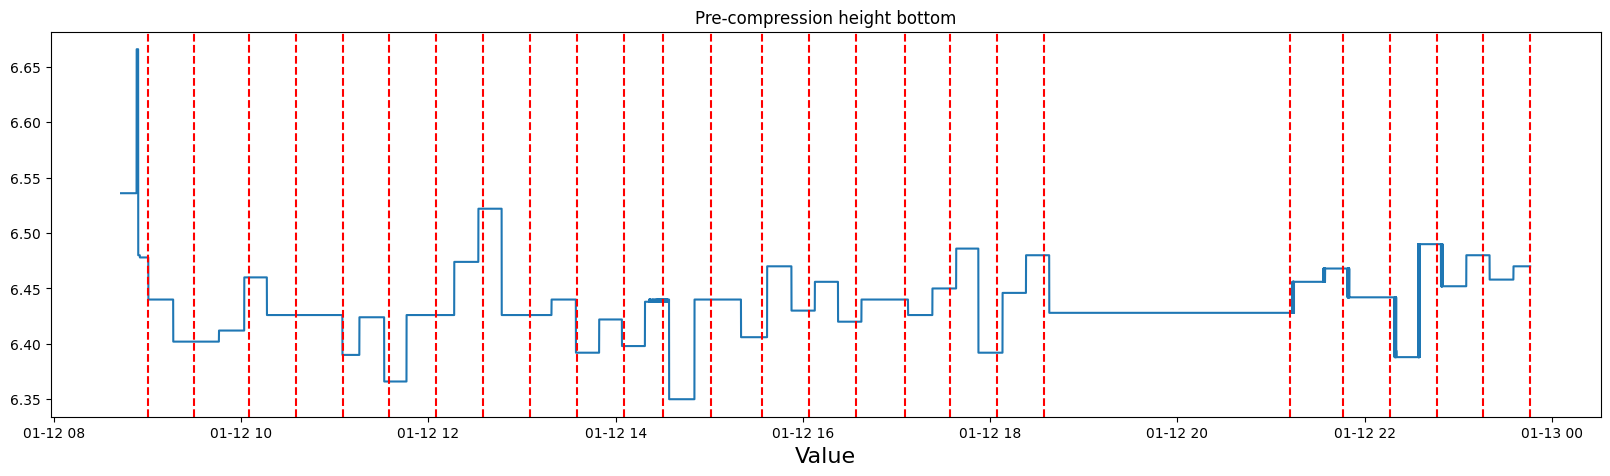

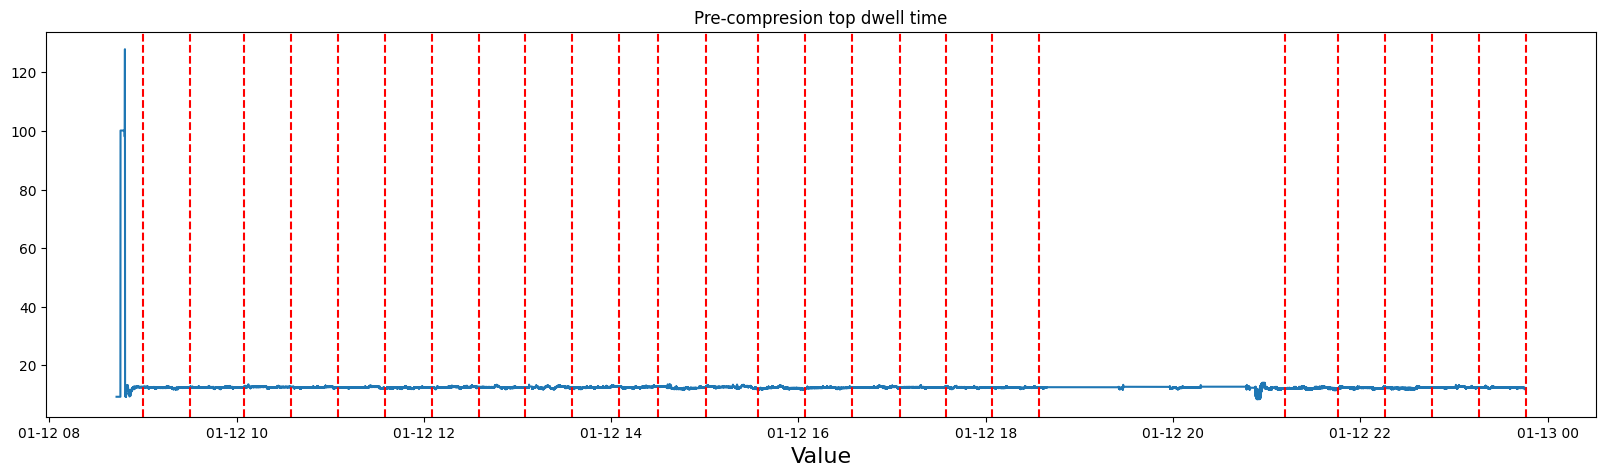

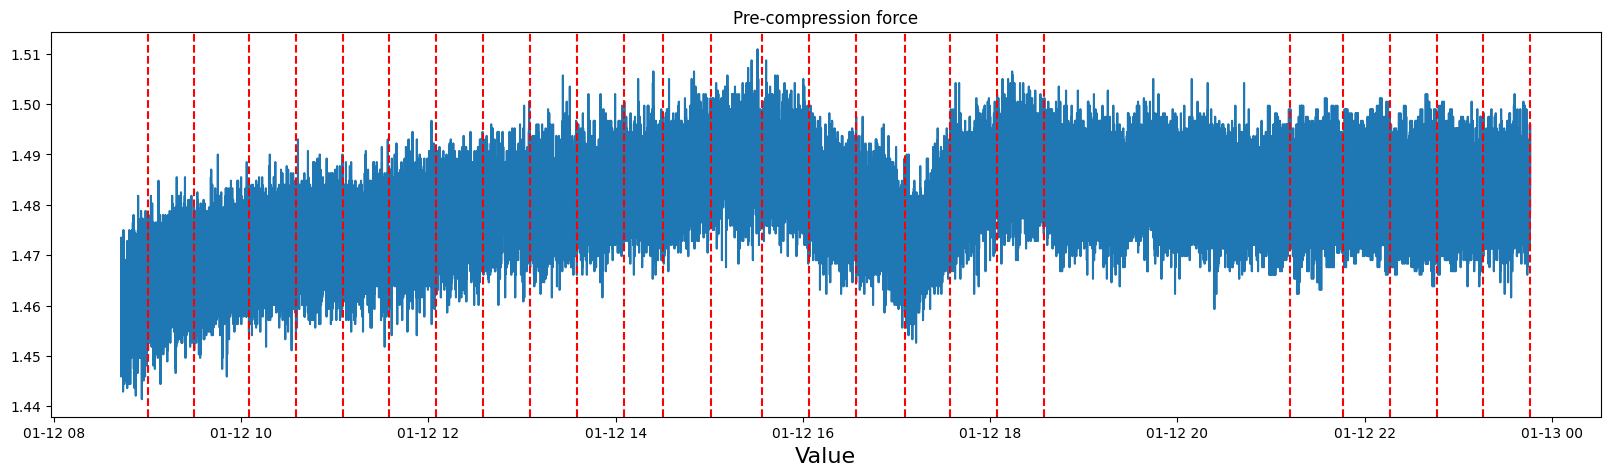

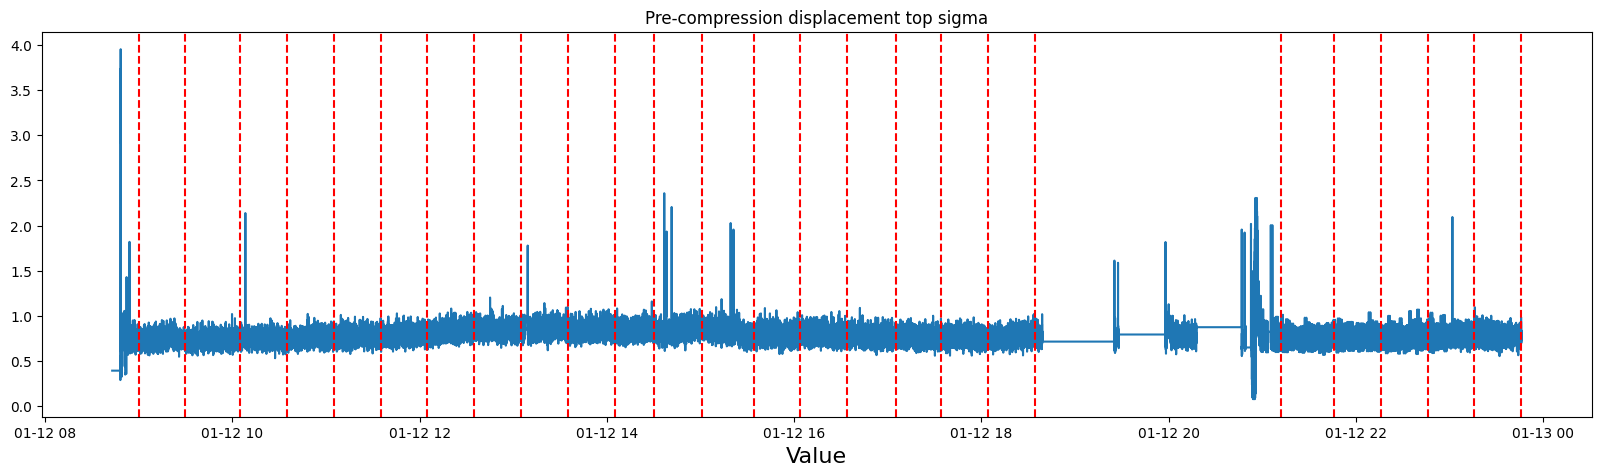

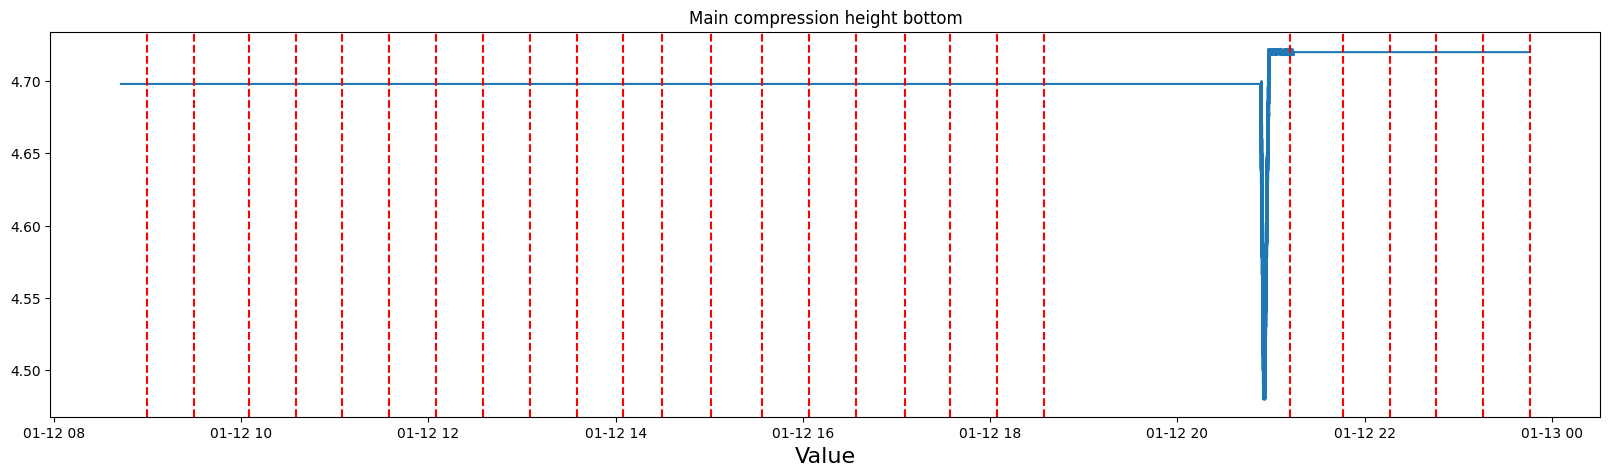

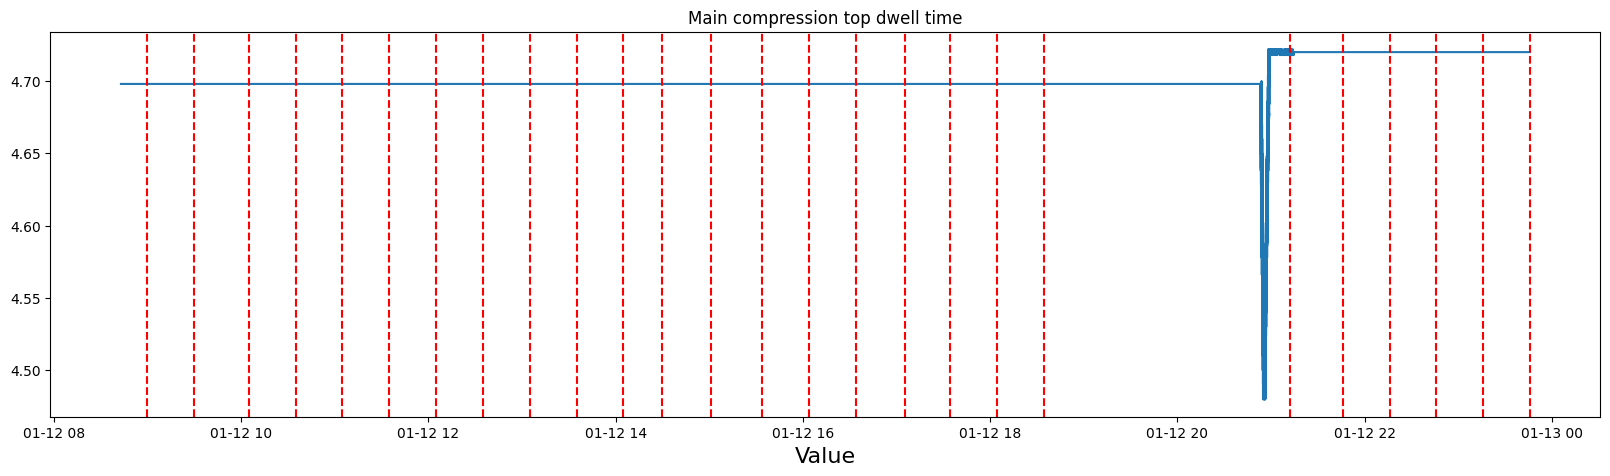

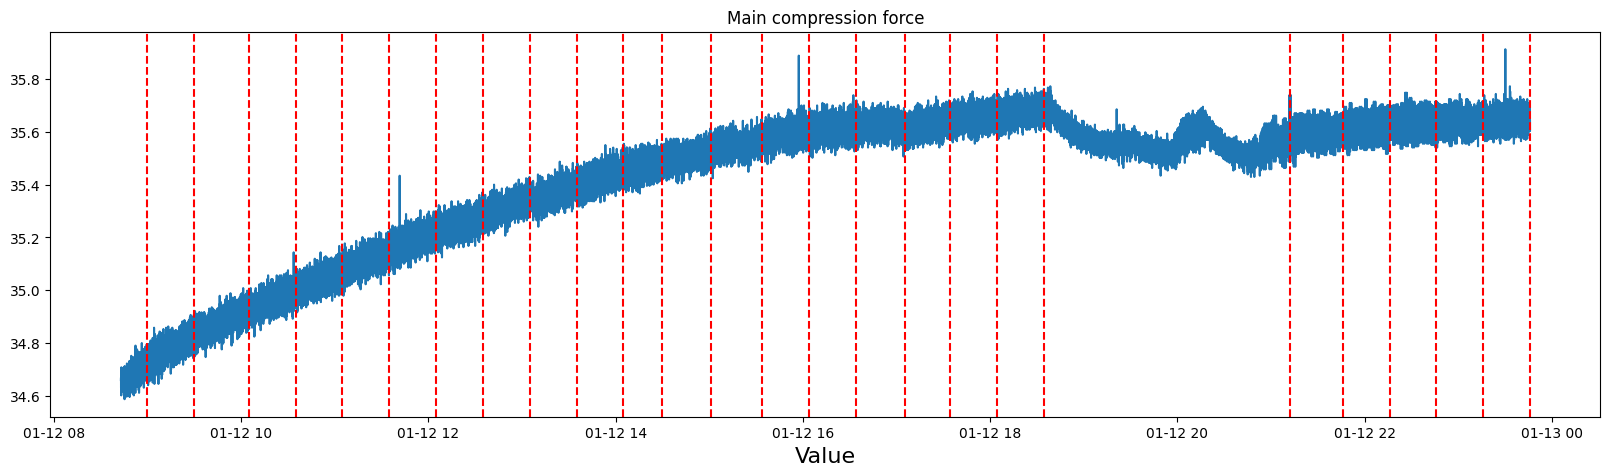

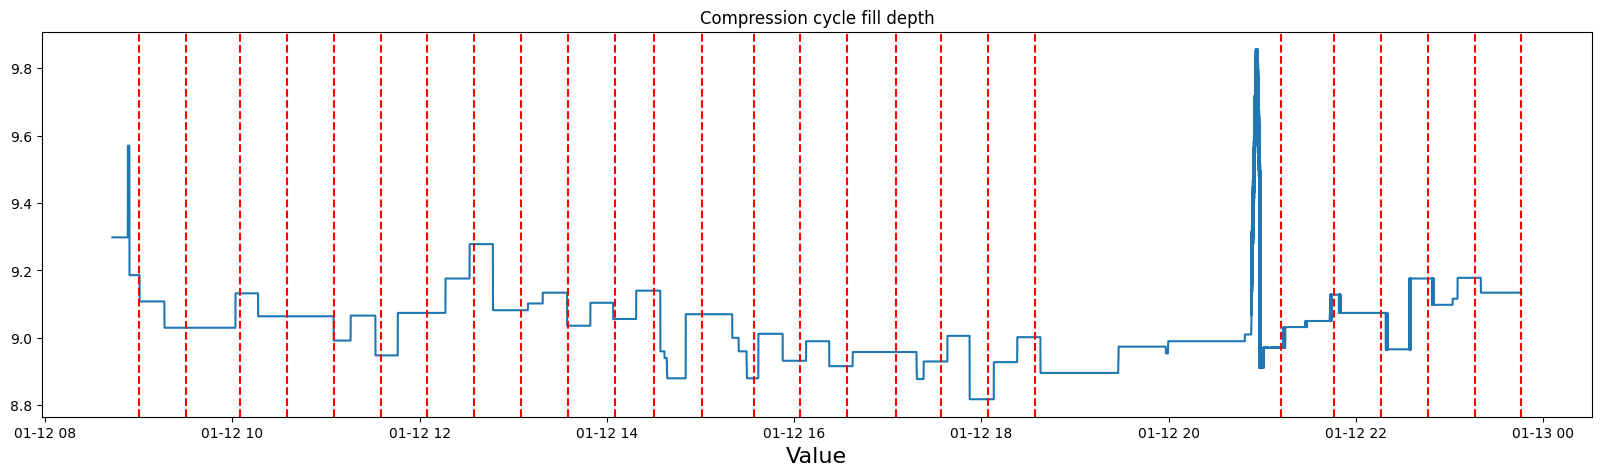

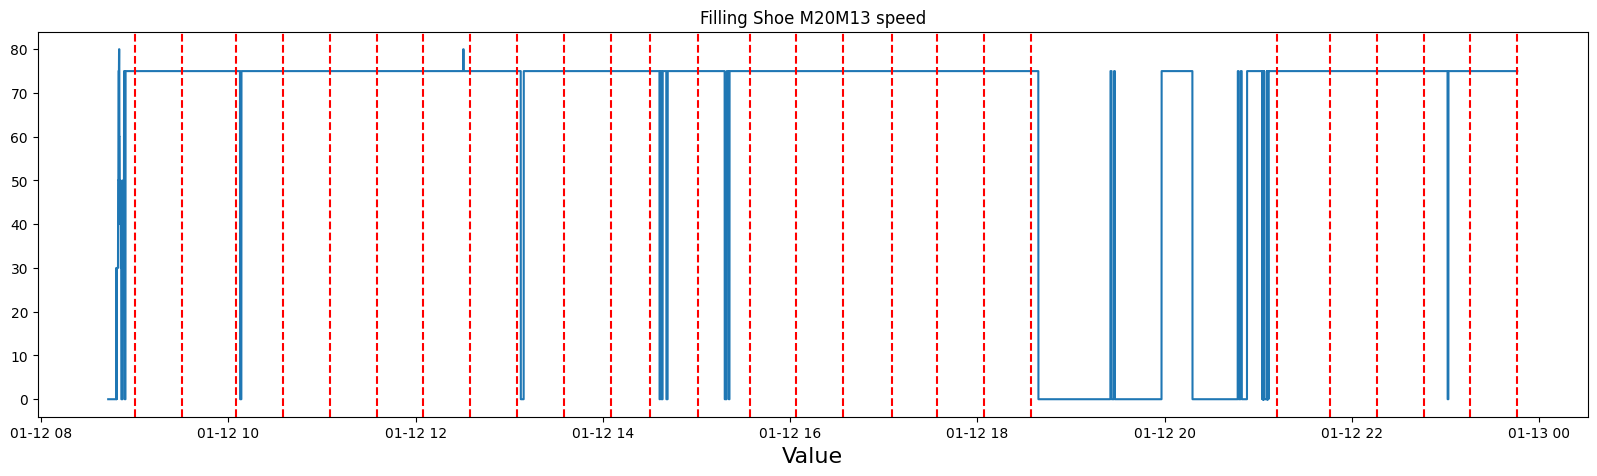

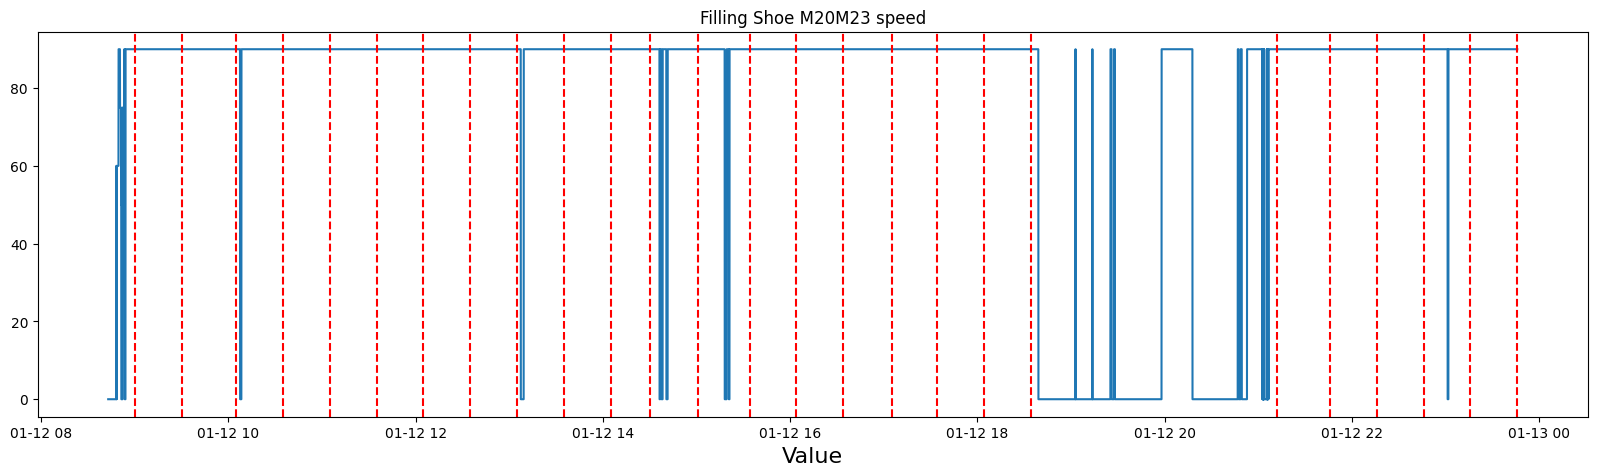

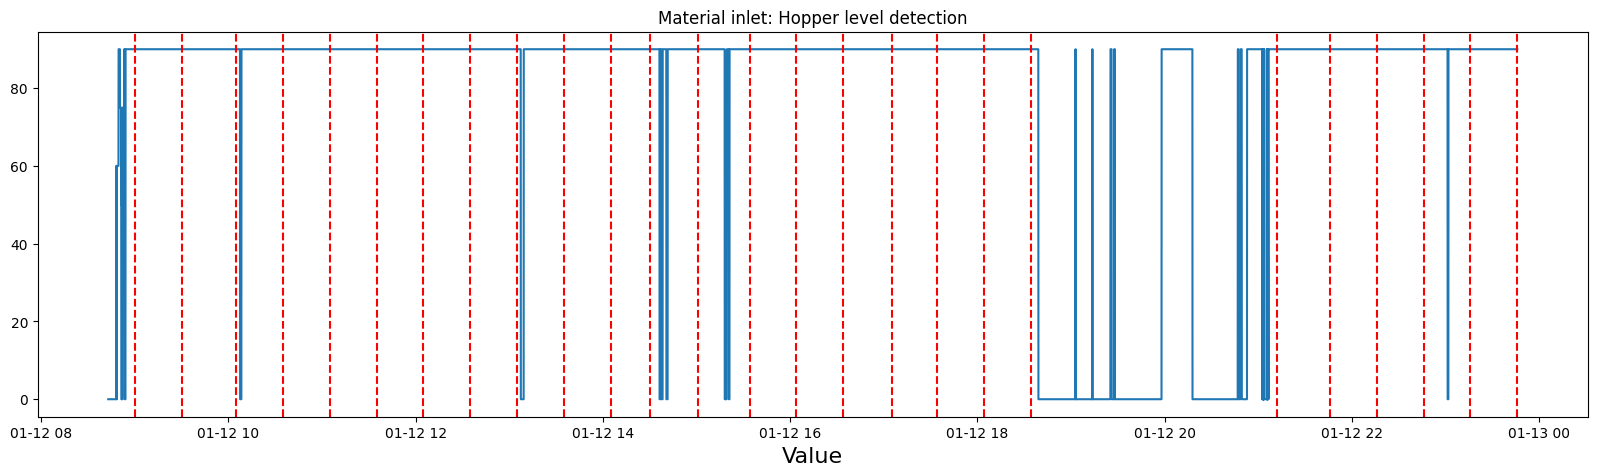

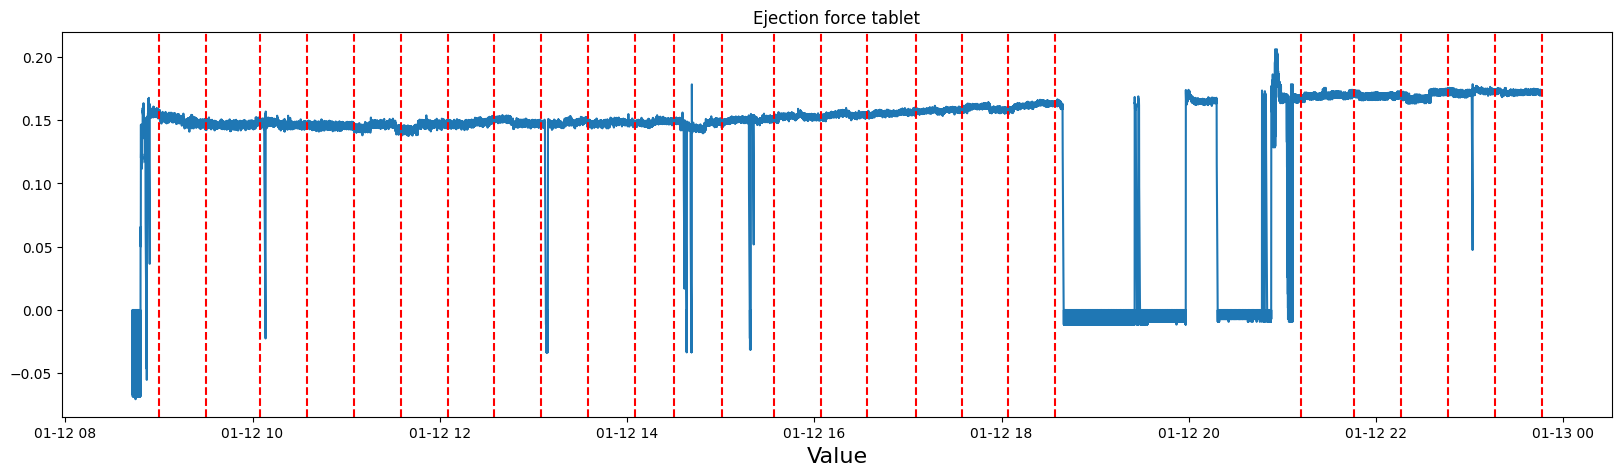

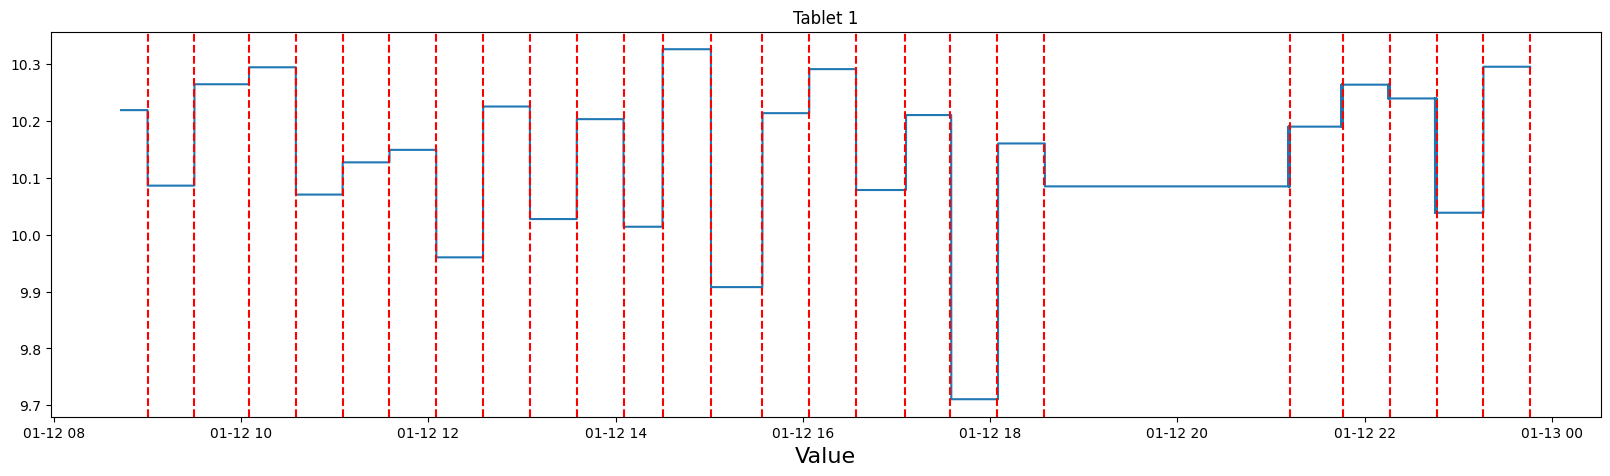

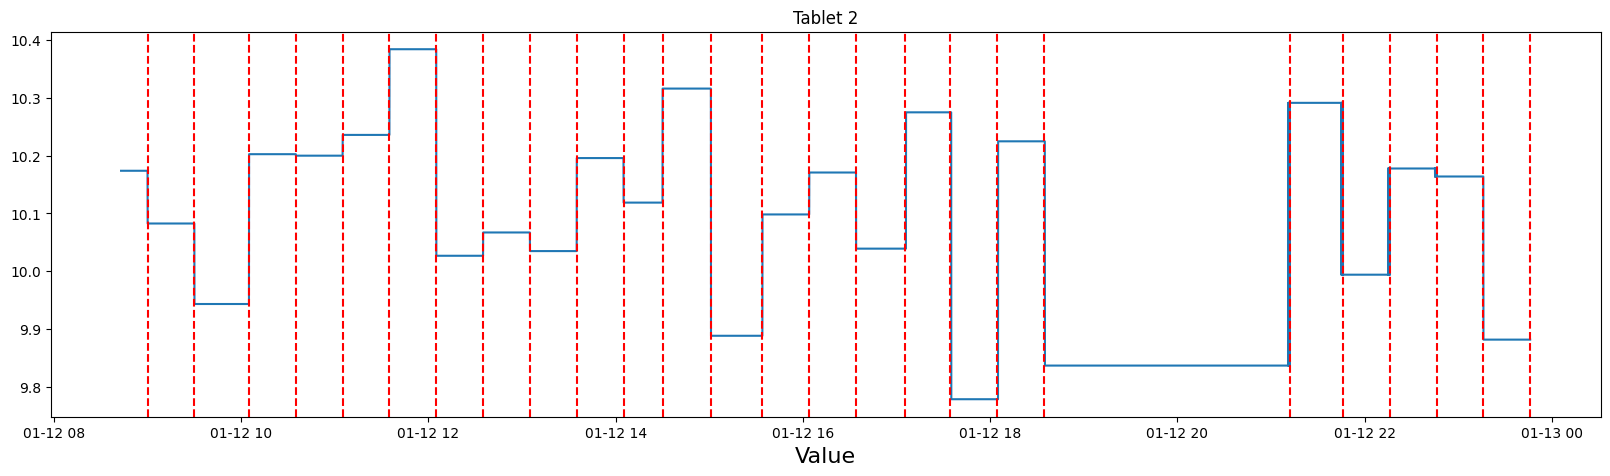

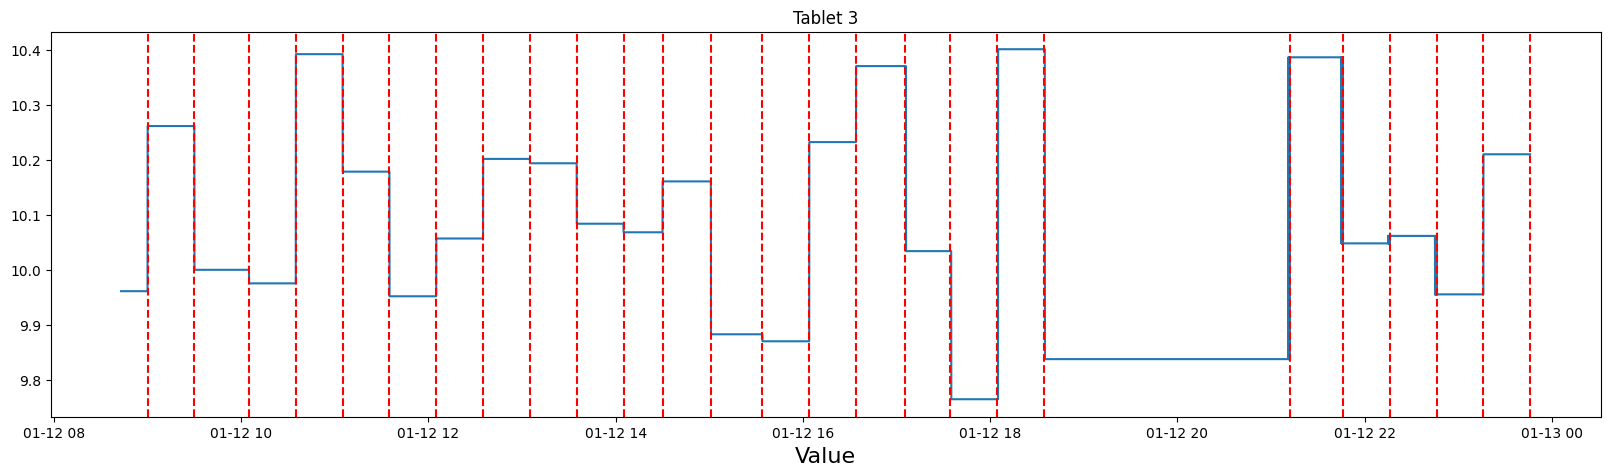

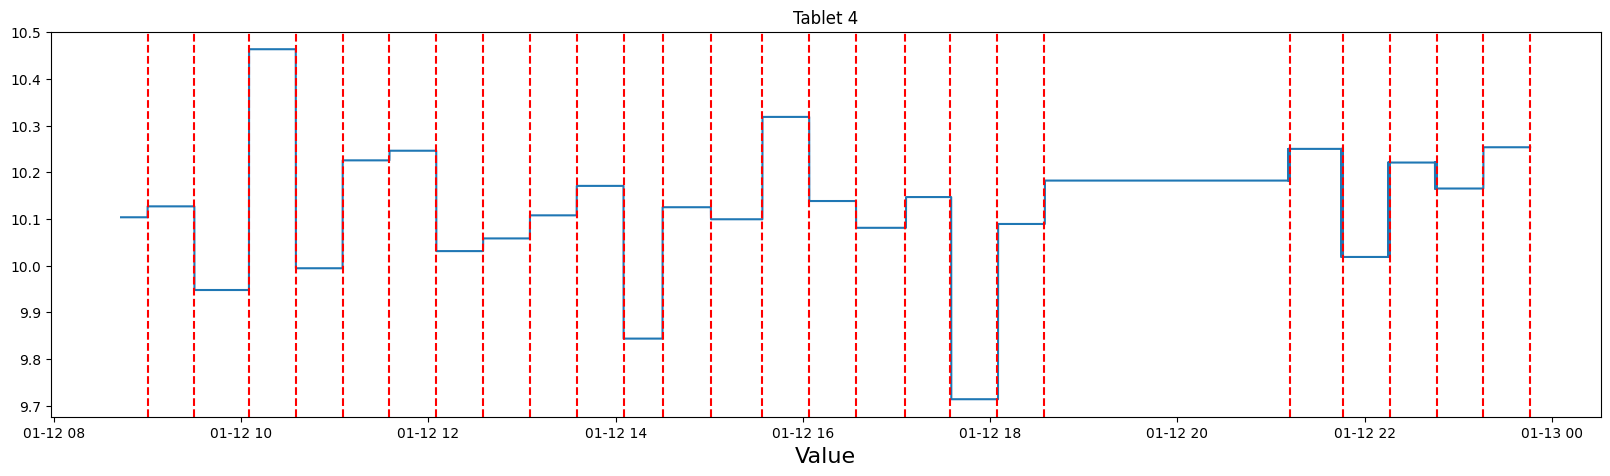

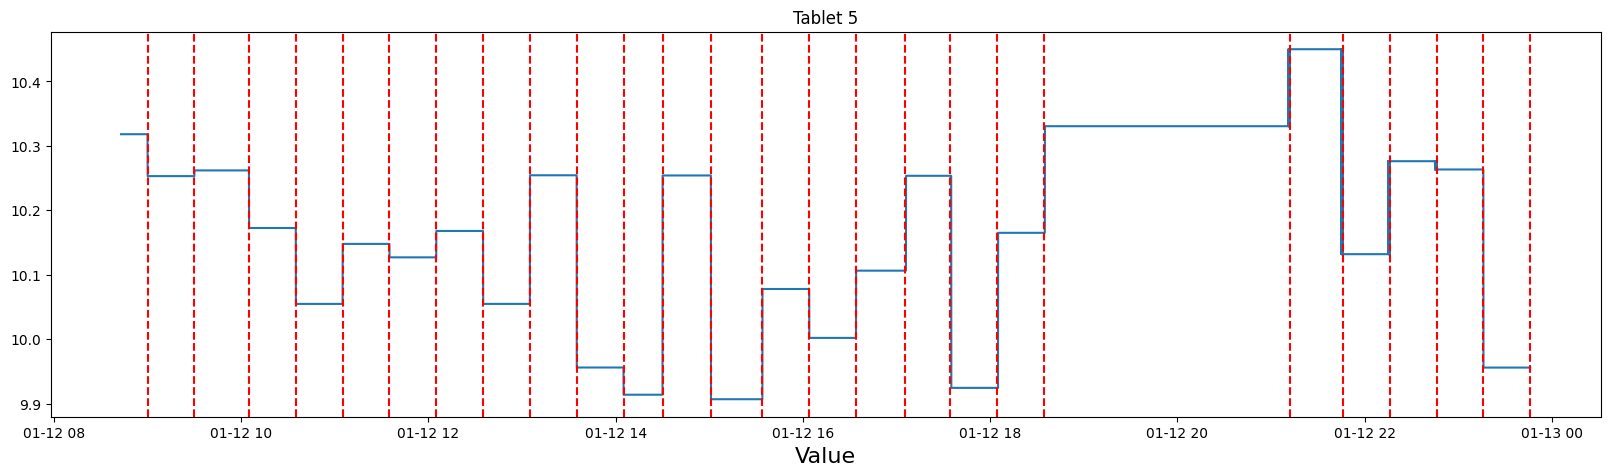

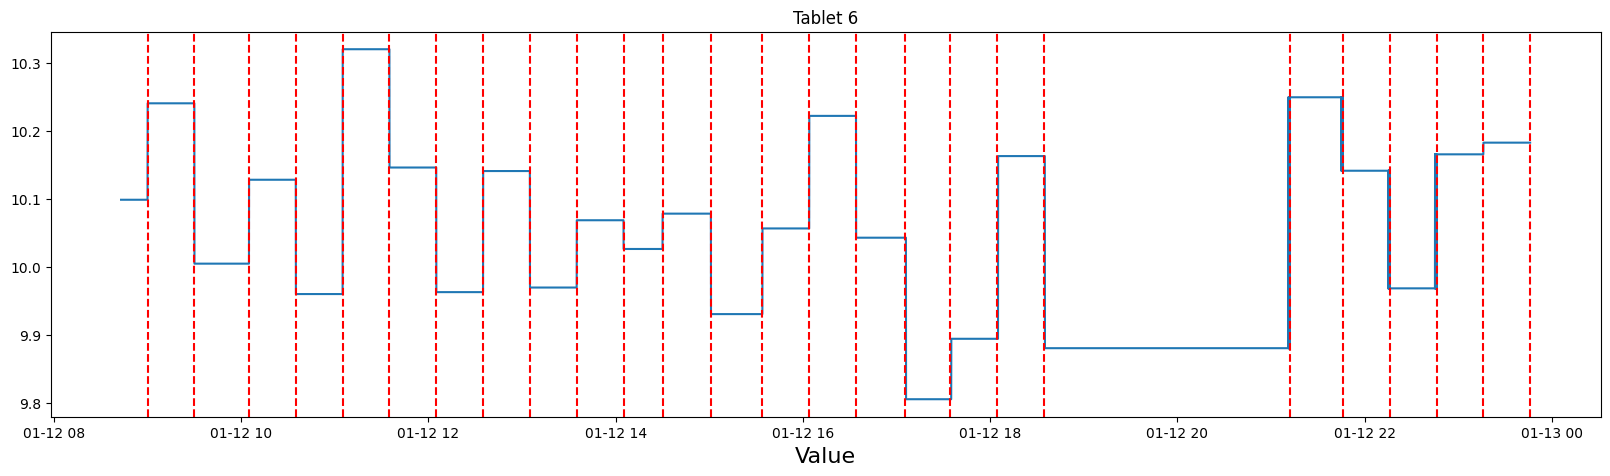

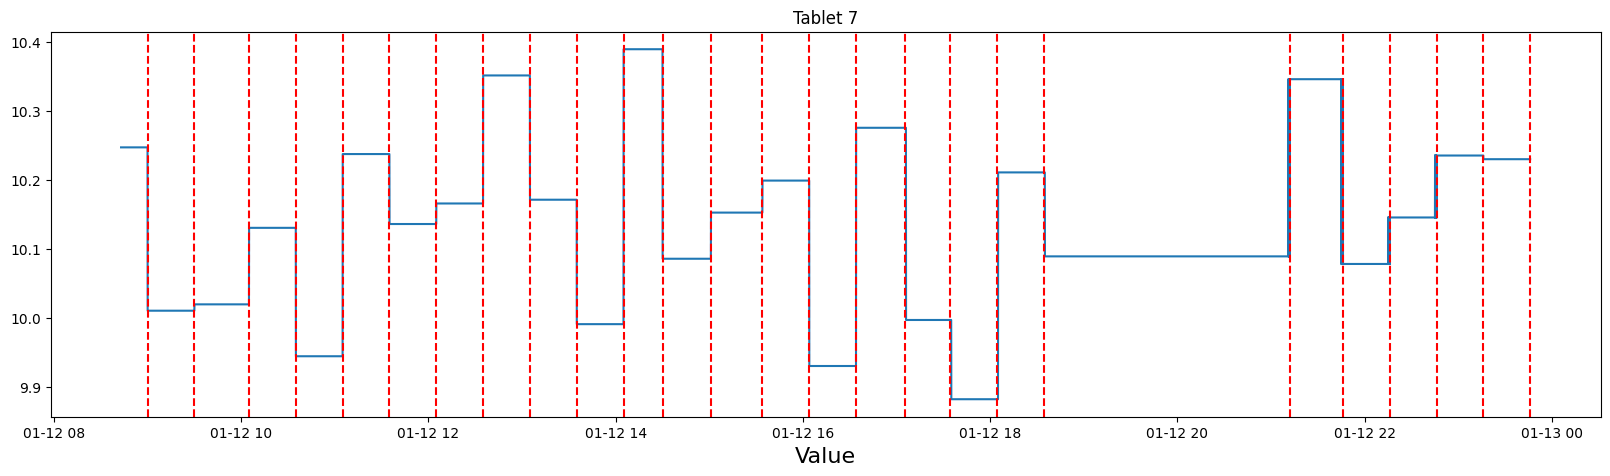

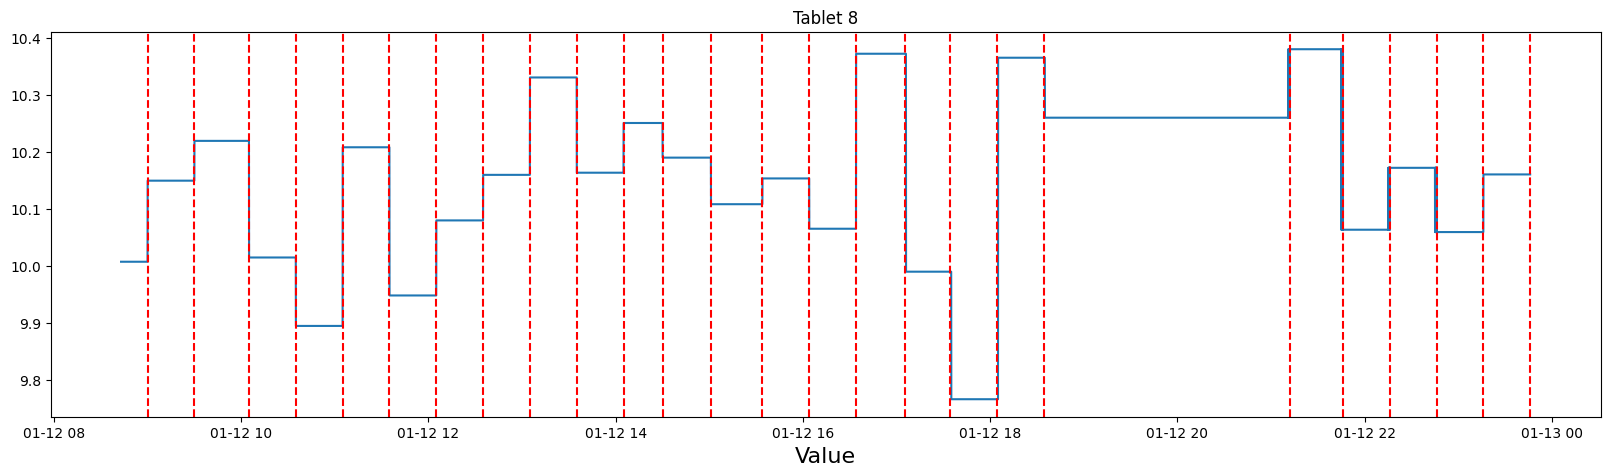

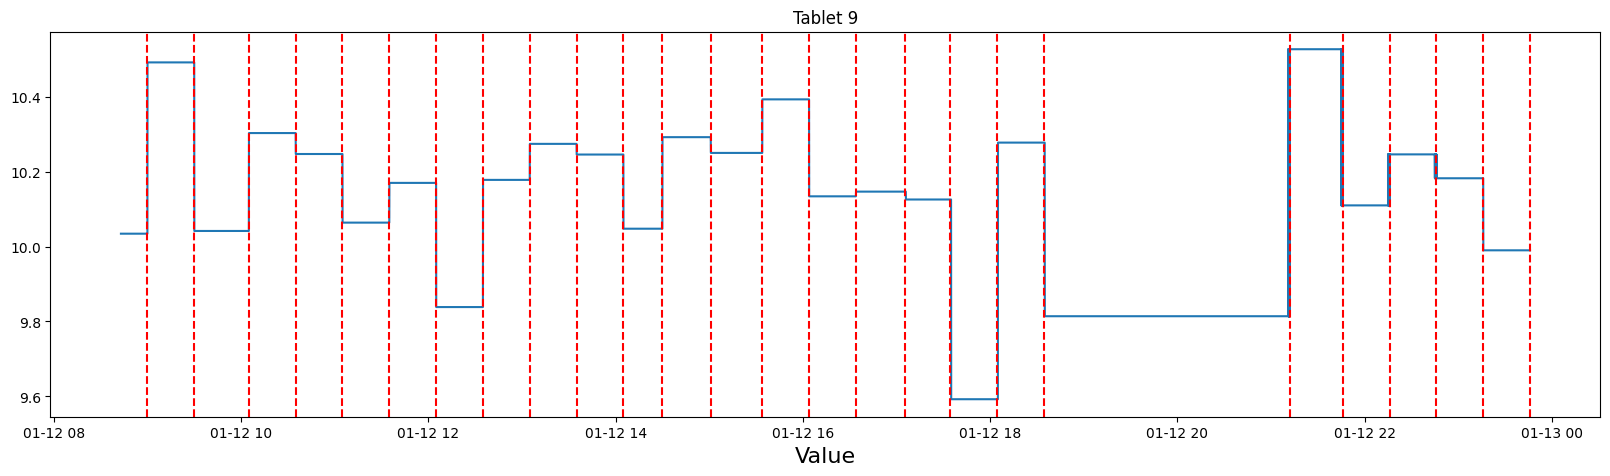

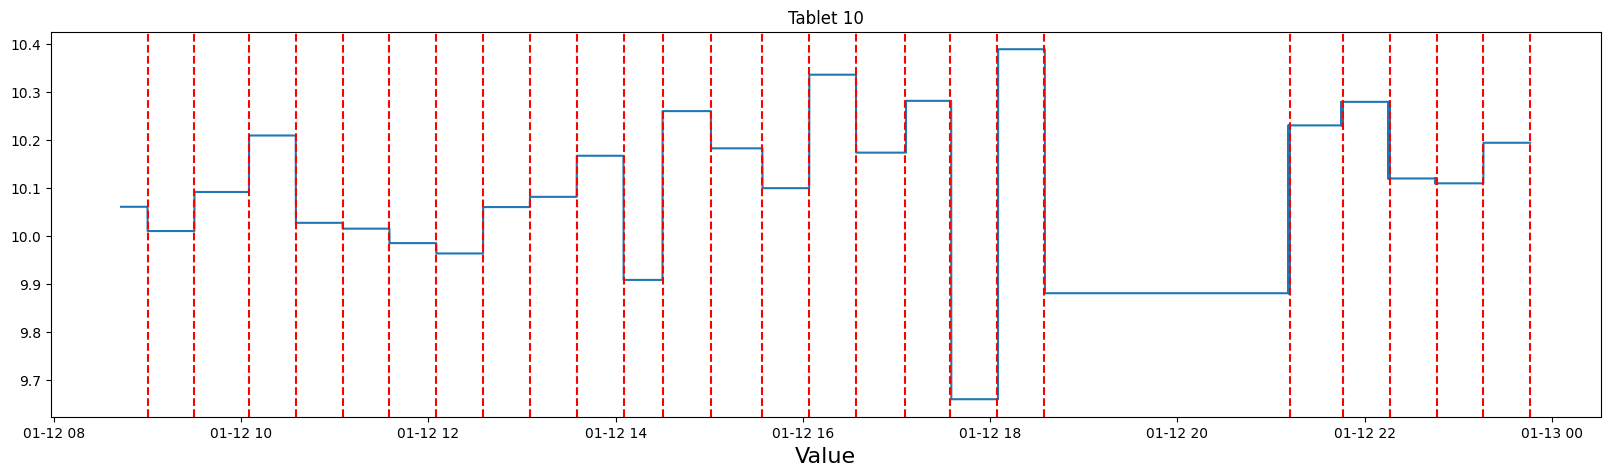

In [24]:
import matplotlib.pyplot as plt



# KDA和時間序列圖
for col in result["API"].columns:
    if col not in ["TimeStamp", "Batch", "sample_time", "sample_id"]:
        plt.figure(figsize=(20, 5))
        plt.plot(result['API']["TimeStamp"], result['API'][col])

        for sample_time in content_first_day['Time']:
            plt.axvline(sample_time, color='r', linestyle='--')

        plt.title(col)
        plt.xlabel('Value', fontsize=16)
        plt.show()